# Deep Learning Systems: CNN Image Classification on CIFAR-10

**Author:** Tim Wilcoxson  
**Course:** Project 4 — Deep Learning Systems  
**Date:** February 2026  

This notebook trains and compares two CNN architectures on CIFAR-10:
- **Baseline CNN** — a standard convolutional network
- **Batch Normalization CNN** — the same architecture with BatchNorm layers added

The controlled experiment isolates the effect of Batch Normalization (Ioffe & Szegedy, 2015) on convergence speed, training stability, and classification accuracy.

---
## 1. Setup & Configuration

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_recall_fscore_support
)

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.10.0
Torchvision version: 0.25.0


In [2]:
# -- Global constants -------------------------------------------------------
SEED = 42
BATCH_SIZE = 128
NUM_EPOCHS = 30
LEARNING_RATE = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
STEP_SIZE = 10
GAMMA = 0.1
NUM_CLASSES = 10
TRAIN_SIZE = 45000
VAL_SIZE = 5000

CIFAR10_CLASSES = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Colorblind-friendly palette (Wong, 2011)
PALETTE = [
    '#0072B2',  # blue
    '#D55E00',  # vermillion
    '#009E73',  # green
    '#CC79A7',  # pink
    '#F0E442',  # yellow
    '#56B4E9',  # sky blue
    '#E69F00',  # orange
    '#000000',  # black
]
COLOR_BASELINE = PALETTE[0]  # blue
COLOR_BATCHNORM = PALETTE[1]  # vermillion

# Directories
PROJECT_DIR = '.'
DATA_DIR = f'{PROJECT_DIR}/data'
FIGURES_DIR = f'{PROJECT_DIR}/figures'
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Reproducibility
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Mode helpers (recursive — required for BatchNorm submodules)
def set_inference_mode(model):
    """Set model and all submodules to inference mode (uses running stats for BN)."""
    for m in model.modules():
        m.training = False
    return model

set_seed()

# Device
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f"Device: {DEVICE}")
print(f"Seed: {SEED}")
print(f"Epochs: {NUM_EPOCHS}, Batch size: {BATCH_SIZE}")
print(f"LR: {LEARNING_RATE}, Momentum: {MOMENTUM}, Weight decay: {WEIGHT_DECAY}")

Device: mps
Seed: 42
Epochs: 30, Batch size: 128
LR: 0.01, Momentum: 0.9, Weight decay: 0.0005


---
## 2. Data Loading & Exploration

In [3]:
# -- CIFAR-10 transforms ----------------------------------------------------
# Training: augmentation + normalization
# Test/Val: normalization only
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Download CIFAR-10
full_train_dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR, train=True, download=True, transform=transform_train
)
test_dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR, train=False, download=True, transform=transform_test
)

print(f"Full training set: {len(full_train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

0.0%

0.0%

0.1%

0.1%

0.1%

0.1%

0.1%

0.2%

0.2%

0.2%

0.2%

0.2%

0.2%

0.3%

0.3%

0.3%

0.3%

0.3%

0.4%

0.4%

0.4%

0.4%

0.4%

0.5%

0.5%

0.5%

0.5%

0.5%

0.6%

0.6%

0.6%

0.6%

0.6%

0.7%

0.7%

0.7%

0.7%

0.7%

0.7%

0.8%

0.8%

0.8%

0.8%

0.8%

0.9%

0.9%

0.9%

0.9%

0.9%

1.0%

1.0%

1.0%

1.0%

1.0%

1.1%

1.1%

1.1%

1.1%

1.1%

1.2%

1.2%

1.2%

1.2%

1.2%

1.2%

1.3%

1.3%

1.3%

1.3%

1.3%

1.4%

1.4%

1.4%

1.4%

1.4%

1.5%

1.5%

1.5%

1.5%

1.5%

1.6%

1.6%

1.6%

1.6%

1.6%

1.7%

1.7%

1.7%

1.7%

1.7%

1.7%

1.8%

1.8%

1.8%

1.8%

1.8%

1.9%

1.9%

1.9%

1.9%

1.9%

2.0%

2.0%

2.0%

2.0%

2.0%

2.1%

2.1%

2.1%

2.1%

2.1%

2.2%

2.2%

2.2%

2.2%

2.2%

2.2%

2.3%

2.3%

2.3%

2.3%

2.3%

2.4%

2.4%

2.4%

2.4%

2.4%

2.5%

2.5%

2.5%

2.5%

2.5%

2.6%

2.6%

2.6%

2.6%

2.6%

2.7%

2.7%

2.7%

2.7%

2.7%

2.7%

2.8%

2.8%

2.8%

2.8%

2.8%

2.9%

2.9%

2.9%

2.9%

2.9%

3.0%

3.0%

3.0%

3.0%

3.0%

3.1%

3.1%

3.1%

3.1%

3.1%

3.2%

3.2%

3.2%

3.2%

3.2%

3.2%

3.3%

3.3%

3.3%

3.3%

3.3%

3.4%

3.4%

3.4%

3.4%

3.4%

3.5%

3.5%

3.5%

3.5%

3.5%

3.6%

3.6%

3.6%

3.6%

3.6%

3.7%

3.7%

3.7%

3.7%

3.7%

3.7%

3.8%

3.8%

3.8%

3.8%

3.8%

3.9%

3.9%

3.9%

3.9%

3.9%

4.0%

4.0%

4.0%

4.0%

4.0%

4.1%

4.1%

4.1%

4.1%

4.1%

4.2%

4.2%

4.2%

4.2%

4.2%

4.2%

4.3%

4.3%

4.3%

4.3%

4.3%

4.4%

4.4%

4.4%

4.4%

4.4%

4.5%

4.5%

4.5%

4.5%

4.5%

4.6%

4.6%

4.6%

4.6%

4.6%

4.7%

4.7%

4.7%

4.7%

4.7%

4.7%

4.8%

4.8%

4.8%

4.8%

4.8%

4.9%

4.9%

4.9%

4.9%

4.9%

5.0%

5.0%

5.0%

5.0%

5.0%

5.1%

5.1%

5.1%

5.1%

5.1%

5.2%

5.2%

5.2%

5.2%

5.2%

5.2%

5.3%

5.3%

5.3%

5.3%

5.3%

5.4%

5.4%

5.4%

5.4%

5.4%

5.5%

5.5%

5.5%

5.5%

5.5%

5.6%

5.6%

5.6%

5.6%

5.6%

5.7%

5.7%

5.7%

5.7%

5.7%

5.7%

5.8%

5.8%

5.8%

5.8%

5.8%

5.9%

5.9%

5.9%

5.9%

5.9%

6.0%

6.0%

6.0%

6.0%

6.0%

6.1%

6.1%

6.1%

6.1%

6.1%

6.2%

6.2%

6.2%

6.2%

6.2%

6.2%

6.3%

6.3%

6.3%

6.3%

6.3%

6.4%

6.4%

6.4%

6.4%

6.4%

6.5%

6.5%

6.5%

6.5%

6.5%

6.6%

6.6%

6.6%

6.6%

6.6%

6.6%

6.7%

6.7%

6.7%

6.7%

6.7%

6.8%

6.8%

6.8%

6.8%

6.8%

6.9%

6.9%

6.9%

6.9%

6.9%

7.0%

7.0%

7.0%

7.0%

7.0%

7.1%

7.1%

7.1%

7.1%

7.1%

7.1%

7.2%

7.2%

7.2%

7.2%

7.2%

7.3%

7.3%

7.3%

7.3%

7.3%

7.4%

7.4%

7.4%

7.4%

7.4%

7.5%

7.5%

7.5%

7.5%

7.5%

7.6%

7.6%

7.6%

7.6%

7.6%

7.6%

7.7%

7.7%

7.7%

7.7%

7.7%

7.8%

7.8%

7.8%

7.8%

7.8%

7.9%

7.9%

7.9%

7.9%

7.9%

8.0%

8.0%

8.0%

8.0%

8.0%

8.1%

8.1%

8.1%

8.1%

8.1%

8.1%

8.2%

8.2%

8.2%

8.2%

8.2%

8.3%

8.3%

8.3%

8.3%

8.3%

8.4%

8.4%

8.4%

8.4%

8.4%

8.5%

8.5%

8.5%

8.5%

8.5%

8.6%

8.6%

8.6%

8.6%

8.6%

8.6%

8.7%

8.7%

8.7%

8.7%

8.7%

8.8%

8.8%

8.8%

8.8%

8.8%

8.9%

8.9%

8.9%

8.9%

8.9%

9.0%

9.0%

9.0%

9.0%

9.0%

9.1%

9.1%

9.1%

9.1%

9.1%

9.1%

9.2%

9.2%

9.2%

9.2%

9.2%

9.3%

9.3%

9.3%

9.3%

9.3%

9.4%

9.4%

9.4%

9.4%

9.4%

9.5%

9.5%

9.5%

9.5%

9.5%

9.6%

9.6%

9.6%

9.6%

9.6%

9.6%

9.7%

9.7%

9.7%

9.7%

9.7%

9.8%

9.8%

9.8%

9.8%

9.8%

9.9%

9.9%

9.9%

9.9%

9.9%

10.0%

10.0%

10.0%

10.0%

10.0%

10.1%

10.1%

10.1%

10.1%

10.1%

10.1%

10.2%

10.2%

10.2%

10.2%

10.2%

10.3%

10.3%

10.3%

10.3%

10.3%

10.4%

10.4%

10.4%

10.4%

10.4%

10.5%

10.5%

10.5%

10.5%

10.5%

10.6%

10.6%

10.6%

10.6%

10.6%

10.6%

10.7%

10.7%

10.7%

10.7%

10.7%

10.8%

10.8%

10.8%

10.8%

10.8%

10.9%

10.9%

10.9%

10.9%

10.9%

11.0%

11.0%

11.0%

11.0%

11.0%

11.1%

11.1%

11.1%

11.1%

11.1%

11.1%

11.2%

11.2%

11.2%

11.2%

11.2%

11.3%

11.3%

11.3%

11.3%

11.3%

11.4%

11.4%

11.4%

11.4%

11.4%

11.5%

11.5%

11.5%

11.5%

11.5%

11.6%

11.6%

11.6%

11.6%

11.6%

11.6%

11.7%

11.7%

11.7%

11.7%

11.7%

11.8%

11.8%

11.8%

11.8%

11.8%

11.9%

11.9%

11.9%

11.9%

11.9%

12.0%

12.0%

12.0%

12.0%

12.0%

12.1%

12.1%

12.1%

12.1%

12.1%

12.1%

12.2%

12.2%

12.2%

12.2%

12.2%

12.3%

12.3%

12.3%

12.3%

12.3%

12.4%

12.4%

12.4%

12.4%

12.4%

12.5%

12.5%

12.5%

12.5%

12.5%

12.5%

12.6%

12.6%

12.6%

12.6%

12.6%

12.7%

12.7%

12.7%

12.7%

12.7%

12.8%

12.8%

12.8%

12.8%

12.8%

12.9%

12.9%

12.9%

12.9%

12.9%

13.0%

13.0%

13.0%

13.0%

13.0%

13.0%

13.1%

13.1%

13.1%

13.1%

13.1%

13.2%

13.2%

13.2%

13.2%

13.2%

13.3%

13.3%

13.3%

13.3%

13.3%

13.4%

13.4%

13.4%

13.4%

13.4%

13.5%

13.5%

13.5%

13.5%

13.5%

13.5%

13.6%

13.6%

13.6%

13.6%

13.6%

13.7%

13.7%

13.7%

13.7%

13.7%

13.8%

13.8%

13.8%

13.8%

13.8%

13.9%

13.9%

13.9%

13.9%

13.9%

14.0%

14.0%

14.0%

14.0%

14.0%

14.0%

14.1%

14.1%

14.1%

14.1%

14.1%

14.2%

14.2%

14.2%

14.2%

14.2%

14.3%

14.3%

14.3%

14.3%

14.3%

14.4%

14.4%

14.4%

14.4%

14.4%

14.5%

14.5%

14.5%

14.5%

14.5%

14.5%

14.6%

14.6%

14.6%

14.6%

14.6%

14.7%

14.7%

14.7%

14.7%

14.7%

14.8%

14.8%

14.8%

14.8%

14.8%

14.9%

14.9%

14.9%

14.9%

14.9%

15.0%

15.0%

15.0%

15.0%

15.0%

15.0%

15.1%

15.1%

15.1%

15.1%

15.1%

15.2%

15.2%

15.2%

15.2%

15.2%

15.3%

15.3%

15.3%

15.3%

15.3%

15.4%

15.4%

15.4%

15.4%

15.4%

15.5%

15.5%

15.5%

15.5%

15.5%

15.5%

15.6%

15.6%

15.6%

15.6%

15.6%

15.7%

15.7%

15.7%

15.7%

15.7%

15.8%

15.8%

15.8%

15.8%

15.8%

15.9%

15.9%

15.9%

15.9%

15.9%

16.0%

16.0%

16.0%

16.0%

16.0%

16.0%

16.1%

16.1%

16.1%

16.1%

16.1%

16.2%

16.2%

16.2%

16.2%

16.2%

16.3%

16.3%

16.3%

16.3%

16.3%

16.4%

16.4%

16.4%

16.4%

16.4%

16.5%

16.5%

16.5%

16.5%

16.5%

16.5%

16.6%

16.6%

16.6%

16.6%

16.6%

16.7%

16.7%

16.7%

16.7%

16.7%

16.8%

16.8%

16.8%

16.8%

16.8%

16.9%

16.9%

16.9%

16.9%

16.9%

17.0%

17.0%

17.0%

17.0%

17.0%

17.0%

17.1%

17.1%

17.1%

17.1%

17.1%

17.2%

17.2%

17.2%

17.2%

17.2%

17.3%

17.3%

17.3%

17.3%

17.3%

17.4%

17.4%

17.4%

17.4%

17.4%

17.5%

17.5%

17.5%

17.5%

17.5%

17.5%

17.6%

17.6%

17.6%

17.6%

17.6%

17.7%

17.7%

17.7%

17.7%

17.7%

17.8%

17.8%

17.8%

17.8%

17.8%

17.9%

17.9%

17.9%

17.9%

17.9%

18.0%

18.0%

18.0%

18.0%

18.0%

18.0%

18.1%

18.1%

18.1%

18.1%

18.1%

18.2%

18.2%

18.2%

18.2%

18.2%

18.3%

18.3%

18.3%

18.3%

18.3%

18.4%

18.4%

18.4%

18.4%

18.4%

18.5%

18.5%

18.5%

18.5%

18.5%

18.5%

18.6%

18.6%

18.6%

18.6%

18.6%

18.7%

18.7%

18.7%

18.7%

18.7%

18.8%

18.8%

18.8%

18.8%

18.8%

18.9%

18.9%

18.9%

18.9%

18.9%

18.9%

19.0%

19.0%

19.0%

19.0%

19.0%

19.1%

19.1%

19.1%

19.1%

19.1%

19.2%

19.2%

19.2%

19.2%

19.2%

19.3%

19.3%

19.3%

19.3%

19.3%

19.4%

19.4%

19.4%

19.4%

19.4%

19.4%

19.5%

19.5%

19.5%

19.5%

19.5%

19.6%

19.6%

19.6%

19.6%

19.6%

19.7%

19.7%

19.7%

19.7%

19.7%

19.8%

19.8%

19.8%

19.8%

19.8%

19.9%

19.9%

19.9%

19.9%

19.9%

19.9%

20.0%

20.0%

20.0%

20.0%

20.0%

20.1%

20.1%

20.1%

20.1%

20.1%

20.2%

20.2%

20.2%

20.2%

20.2%

20.3%

20.3%

20.3%

20.3%

20.3%

20.4%

20.4%

20.4%

20.4%

20.4%

20.4%

20.5%

20.5%

20.5%

20.5%

20.5%

20.6%

20.6%

20.6%

20.6%

20.6%

20.7%

20.7%

20.7%

20.7%

20.7%

20.8%

20.8%

20.8%

20.8%

20.8%

20.9%

20.9%

20.9%

20.9%

20.9%

20.9%

21.0%

21.0%

21.0%

21.0%

21.0%

21.1%

21.1%

21.1%

21.1%

21.1%

21.2%

21.2%

21.2%

21.2%

21.2%

21.3%

21.3%

21.3%

21.3%

21.3%

21.4%

21.4%

21.4%

21.4%

21.4%

21.4%

21.5%

21.5%

21.5%

21.5%

21.5%

21.6%

21.6%

21.6%

21.6%

21.6%

21.7%

21.7%

21.7%

21.7%

21.7%

21.8%

21.8%

21.8%

21.8%

21.8%

21.9%

21.9%

21.9%

21.9%

21.9%

21.9%

22.0%

22.0%

22.0%

22.0%

22.0%

22.1%

22.1%

22.1%

22.1%

22.1%

22.2%

22.2%

22.2%

22.2%

22.2%

22.3%

22.3%

22.3%

22.3%

22.3%

22.4%

22.4%

22.4%

22.4%

22.4%

22.4%

22.5%

22.5%

22.5%

22.5%

22.5%

22.6%

22.6%

22.6%

22.6%

22.6%

22.7%

22.7%

22.7%

22.7%

22.7%

22.8%

22.8%

22.8%

22.8%

22.8%

22.9%

22.9%

22.9%

22.9%

22.9%

22.9%

23.0%

23.0%

23.0%

23.0%

23.0%

23.1%

23.1%

23.1%

23.1%

23.1%

23.2%

23.2%

23.2%

23.2%

23.2%

23.3%

23.3%

23.3%

23.3%

23.3%

23.4%

23.4%

23.4%

23.4%

23.4%

23.4%

23.5%

23.5%

23.5%

23.5%

23.5%

23.6%

23.6%

23.6%

23.6%

23.6%

23.7%

23.7%

23.7%

23.7%

23.7%

23.8%

23.8%

23.8%

23.8%

23.8%

23.9%

23.9%

23.9%

23.9%

23.9%

23.9%

24.0%

24.0%

24.0%

24.0%

24.0%

24.1%

24.1%

24.1%

24.1%

24.1%

24.2%

24.2%

24.2%

24.2%

24.2%

24.3%

24.3%

24.3%

24.3%

24.3%

24.4%

24.4%

24.4%

24.4%

24.4%

24.4%

24.5%

24.5%

24.5%

24.5%

24.5%

24.6%

24.6%

24.6%

24.6%

24.6%

24.7%

24.7%

24.7%

24.7%

24.7%

24.8%

24.8%

24.8%

24.8%

24.8%

24.9%

24.9%

24.9%

24.9%

24.9%

24.9%

25.0%

25.0%

25.0%

25.0%

25.0%

25.1%

25.1%

25.1%

25.1%

25.1%

25.2%

25.2%

25.2%

25.2%

25.2%

25.3%

25.3%

25.3%

25.3%

25.3%

25.3%

25.4%

25.4%

25.4%

25.4%

25.4%

25.5%

25.5%

25.5%

25.5%

25.5%

25.6%

25.6%

25.6%

25.6%

25.6%

25.7%

25.7%

25.7%

25.7%

25.7%

25.8%

25.8%

25.8%

25.8%

25.8%

25.8%

25.9%

25.9%

25.9%

25.9%

25.9%

26.0%

26.0%

26.0%

26.0%

26.0%

26.1%

26.1%

26.1%

26.1%

26.1%

26.2%

26.2%

26.2%

26.2%

26.2%

26.3%

26.3%

26.3%

26.3%

26.3%

26.3%

26.4%

26.4%

26.4%

26.4%

26.4%

26.5%

26.5%

26.5%

26.5%

26.5%

26.6%

26.6%

26.6%

26.6%

26.6%

26.7%

26.7%

26.7%

26.7%

26.7%

26.8%

26.8%

26.8%

26.8%

26.8%

26.8%

26.9%

26.9%

26.9%

26.9%

26.9%

27.0%

27.0%

27.0%

27.0%

27.0%

27.1%

27.1%

27.1%

27.1%

27.1%

27.2%

27.2%

27.2%

27.2%

27.2%

27.3%

27.3%

27.3%

27.3%

27.3%

27.3%

27.4%

27.4%

27.4%

27.4%

27.4%

27.5%

27.5%

27.5%

27.5%

27.5%

27.6%

27.6%

27.6%

27.6%

27.6%

27.7%

27.7%

27.7%

27.7%

27.7%

27.8%

27.8%

27.8%

27.8%

27.8%

27.8%

27.9%

27.9%

27.9%

27.9%

27.9%

28.0%

28.0%

28.0%

28.0%

28.0%

28.1%

28.1%

28.1%

28.1%

28.1%

28.2%

28.2%

28.2%

28.2%

28.2%

28.3%

28.3%

28.3%

28.3%

28.3%

28.3%

28.4%

28.4%

28.4%

28.4%

28.4%

28.5%

28.5%

28.5%

28.5%

28.5%

28.6%

28.6%

28.6%

28.6%

28.6%

28.7%

28.7%

28.7%

28.7%

28.7%

28.8%

28.8%

28.8%

28.8%

28.8%

28.8%

28.9%

28.9%

28.9%

28.9%

28.9%

29.0%

29.0%

29.0%

29.0%

29.0%

29.1%

29.1%

29.1%

29.1%

29.1%

29.2%

29.2%

29.2%

29.2%

29.2%

29.3%

29.3%

29.3%

29.3%

29.3%

29.3%

29.4%

29.4%

29.4%

29.4%

29.4%

29.5%

29.5%

29.5%

29.5%

29.5%

29.6%

29.6%

29.6%

29.6%

29.6%

29.7%

29.7%

29.7%

29.7%

29.7%

29.8%

29.8%

29.8%

29.8%

29.8%

29.8%

29.9%

29.9%

29.9%

29.9%

29.9%

30.0%

30.0%

30.0%

30.0%

30.0%

30.1%

30.1%

30.1%

30.1%

30.1%

30.2%

30.2%

30.2%

30.2%

30.2%

30.3%

30.3%

30.3%

30.3%

30.3%

30.3%

30.4%

30.4%

30.4%

30.4%

30.4%

30.5%

30.5%

30.5%

30.5%

30.5%

30.6%

30.6%

30.6%

30.6%

30.6%

30.7%

30.7%

30.7%

30.7%

30.7%

30.8%

30.8%

30.8%

30.8%

30.8%

30.8%

30.9%

30.9%

30.9%

30.9%

30.9%

31.0%

31.0%

31.0%

31.0%

31.0%

31.1%

31.1%

31.1%

31.1%

31.1%

31.2%

31.2%

31.2%

31.2%

31.2%

31.3%

31.3%

31.3%

31.3%

31.3%

31.3%

31.4%

31.4%

31.4%

31.4%

31.4%

31.5%

31.5%

31.5%

31.5%

31.5%

31.6%

31.6%

31.6%

31.6%

31.6%

31.7%

31.7%

31.7%

31.7%

31.7%

31.7%

31.8%

31.8%

31.8%

31.8%

31.8%

31.9%

31.9%

31.9%

31.9%

31.9%

32.0%

32.0%

32.0%

32.0%

32.0%

32.1%

32.1%

32.1%

32.1%

32.1%

32.2%

32.2%

32.2%

32.2%

32.2%

32.2%

32.3%

32.3%

32.3%

32.3%

32.3%

32.4%

32.4%

32.4%

32.4%

32.4%

32.5%

32.5%

32.5%

32.5%

32.5%

32.6%

32.6%

32.6%

32.6%

32.6%

32.7%

32.7%

32.7%

32.7%

32.7%

32.7%

32.8%

32.8%

32.8%

32.8%

32.8%

32.9%

32.9%

32.9%

32.9%

32.9%

33.0%

33.0%

33.0%

33.0%

33.0%

33.1%

33.1%

33.1%

33.1%

33.1%

33.2%

33.2%

33.2%

33.2%

33.2%

33.2%

33.3%

33.3%

33.3%

33.3%

33.3%

33.4%

33.4%

33.4%

33.4%

33.4%

33.5%

33.5%

33.5%

33.5%

33.5%

33.6%

33.6%

33.6%

33.6%

33.6%

33.7%

33.7%

33.7%

33.7%

33.7%

33.7%

33.8%

33.8%

33.8%

33.8%

33.8%

33.9%

33.9%

33.9%

33.9%

33.9%

34.0%

34.0%

34.0%

34.0%

34.0%

34.1%

34.1%

34.1%

34.1%

34.1%

34.2%

34.2%

34.2%

34.2%

34.2%

34.2%

34.3%

34.3%

34.3%

34.3%

34.3%

34.4%

34.4%

34.4%

34.4%

34.4%

34.5%

34.5%

34.5%

34.5%

34.5%

34.6%

34.6%

34.6%

34.6%

34.6%

34.7%

34.7%

34.7%

34.7%

34.7%

34.7%

34.8%

34.8%

34.8%

34.8%

34.8%

34.9%

34.9%

34.9%

34.9%

34.9%

35.0%

35.0%

35.0%

35.0%

35.0%

35.1%

35.1%

35.1%

35.1%

35.1%

35.2%

35.2%

35.2%

35.2%

35.2%

35.2%

35.3%

35.3%

35.3%

35.3%

35.3%

35.4%

35.4%

35.4%

35.4%

35.4%

35.5%

35.5%

35.5%

35.5%

35.5%

35.6%

35.6%

35.6%

35.6%

35.6%

35.7%

35.7%

35.7%

35.7%

35.7%

35.7%

35.8%

35.8%

35.8%

35.8%

35.8%

35.9%

35.9%

35.9%

35.9%

35.9%

36.0%

36.0%

36.0%

36.0%

36.0%

36.1%

36.1%

36.1%

36.1%

36.1%

36.2%

36.2%

36.2%

36.2%

36.2%

36.2%

36.3%

36.3%

36.3%

36.3%

36.3%

36.4%

36.4%

36.4%

36.4%

36.4%

36.5%

36.5%

36.5%

36.5%

36.5%

36.6%

36.6%

36.6%

36.6%

36.6%

36.7%

36.7%

36.7%

36.7%

36.7%

36.7%

36.8%

36.8%

36.8%

36.8%

36.8%

36.9%

36.9%

36.9%

36.9%

36.9%

37.0%

37.0%

37.0%

37.0%

37.0%

37.1%

37.1%

37.1%

37.1%

37.1%

37.2%

37.2%

37.2%

37.2%

37.2%

37.2%

37.3%

37.3%

37.3%

37.3%

37.3%

37.4%

37.4%

37.4%

37.4%

37.4%

37.5%

37.5%

37.5%

37.5%

37.5%

37.6%

37.6%

37.6%

37.6%

37.6%

37.6%

37.7%

37.7%

37.7%

37.7%

37.7%

37.8%

37.8%

37.8%

37.8%

37.8%

37.9%

37.9%

37.9%

37.9%

37.9%

38.0%

38.0%

38.0%

38.0%

38.0%

38.1%

38.1%

38.1%

38.1%

38.1%

38.1%

38.2%

38.2%

38.2%

38.2%

38.2%

38.3%

38.3%

38.3%

38.3%

38.3%

38.4%

38.4%

38.4%

38.4%

38.4%

38.5%

38.5%

38.5%

38.5%

38.5%

38.6%

38.6%

38.6%

38.6%

38.6%

38.6%

38.7%

38.7%

38.7%

38.7%

38.7%

38.8%

38.8%

38.8%

38.8%

38.8%

38.9%

38.9%

38.9%

38.9%

38.9%

39.0%

39.0%

39.0%

39.0%

39.0%

39.1%

39.1%

39.1%

39.1%

39.1%

39.1%

39.2%

39.2%

39.2%

39.2%

39.2%

39.3%

39.3%

39.3%

39.3%

39.3%

39.4%

39.4%

39.4%

39.4%

39.4%

39.5%

39.5%

39.5%

39.5%

39.5%

39.6%

39.6%

39.6%

39.6%

39.6%

39.6%

39.7%

39.7%

39.7%

39.7%

39.7%

39.8%

39.8%

39.8%

39.8%

39.8%

39.9%

39.9%

39.9%

39.9%

39.9%

40.0%

40.0%

40.0%

40.0%

40.0%

40.1%

40.1%

40.1%

40.1%

40.1%

40.1%

40.2%

40.2%

40.2%

40.2%

40.2%

40.3%

40.3%

40.3%

40.3%

40.3%

40.4%

40.4%

40.4%

40.4%

40.4%

40.5%

40.5%

40.5%

40.5%

40.5%

40.6%

40.6%

40.6%

40.6%

40.6%

40.6%

40.7%

40.7%

40.7%

40.7%

40.7%

40.8%

40.8%

40.8%

40.8%

40.8%

40.9%

40.9%

40.9%

40.9%

40.9%

41.0%

41.0%

41.0%

41.0%

41.0%

41.1%

41.1%

41.1%

41.1%

41.1%

41.1%

41.2%

41.2%

41.2%

41.2%

41.2%

41.3%

41.3%

41.3%

41.3%

41.3%

41.4%

41.4%

41.4%

41.4%

41.4%

41.5%

41.5%

41.5%

41.5%

41.5%

41.6%

41.6%

41.6%

41.6%

41.6%

41.6%

41.7%

41.7%

41.7%

41.7%

41.7%

41.8%

41.8%

41.8%

41.8%

41.8%

41.9%

41.9%

41.9%

41.9%

41.9%

42.0%

42.0%

42.0%

42.0%

42.0%

42.1%

42.1%

42.1%

42.1%

42.1%

42.1%

42.2%

42.2%

42.2%

42.2%

42.2%

42.3%

42.3%

42.3%

42.3%

42.3%

42.4%

42.4%

42.4%

42.4%

42.4%

42.5%

42.5%

42.5%

42.5%

42.5%

42.6%

42.6%

42.6%

42.6%

42.6%

42.6%

42.7%

42.7%

42.7%

42.7%

42.7%

42.8%

42.8%

42.8%

42.8%

42.8%

42.9%

42.9%

42.9%

42.9%

42.9%

43.0%

43.0%

43.0%

43.0%

43.0%

43.1%

43.1%

43.1%

43.1%

43.1%

43.1%

43.2%

43.2%

43.2%

43.2%

43.2%

43.3%

43.3%

43.3%

43.3%

43.3%

43.4%

43.4%

43.4%

43.4%

43.4%

43.5%

43.5%

43.5%

43.5%

43.5%

43.6%

43.6%

43.6%

43.6%

43.6%

43.6%

43.7%

43.7%

43.7%

43.7%

43.7%

43.8%

43.8%

43.8%

43.8%

43.8%

43.9%

43.9%

43.9%

43.9%

43.9%

44.0%

44.0%

44.0%

44.0%

44.0%

44.0%

44.1%

44.1%

44.1%

44.1%

44.1%

44.2%

44.2%

44.2%

44.2%

44.2%

44.3%

44.3%

44.3%

44.3%

44.3%

44.4%

44.4%

44.4%

44.4%

44.4%

44.5%

44.5%

44.5%

44.5%

44.5%

44.5%

44.6%

44.6%

44.6%

44.6%

44.6%

44.7%

44.7%

44.7%

44.7%

44.7%

44.8%

44.8%

44.8%

44.8%

44.8%

44.9%

44.9%

44.9%

44.9%

44.9%

45.0%

45.0%

45.0%

45.0%

45.0%

45.0%

45.1%

45.1%

45.1%

45.1%

45.1%

45.2%

45.2%

45.2%

45.2%

45.2%

45.3%

45.3%

45.3%

45.3%

45.3%

45.4%

45.4%

45.4%

45.4%

45.4%

45.5%

45.5%

45.5%

45.5%

45.5%

45.5%

45.6%

45.6%

45.6%

45.6%

45.6%

45.7%

45.7%

45.7%

45.7%

45.7%

45.8%

45.8%

45.8%

45.8%

45.8%

45.9%

45.9%

45.9%

45.9%

45.9%

46.0%

46.0%

46.0%

46.0%

46.0%

46.0%

46.1%

46.1%

46.1%

46.1%

46.1%

46.2%

46.2%

46.2%

46.2%

46.2%

46.3%

46.3%

46.3%

46.3%

46.3%

46.4%

46.4%

46.4%

46.4%

46.4%

46.5%

46.5%

46.5%

46.5%

46.5%

46.5%

46.6%

46.6%

46.6%

46.6%

46.6%

46.7%

46.7%

46.7%

46.7%

46.7%

46.8%

46.8%

46.8%

46.8%

46.8%

46.9%

46.9%

46.9%

46.9%

46.9%

47.0%

47.0%

47.0%

47.0%

47.0%

47.0%

47.1%

47.1%

47.1%

47.1%

47.1%

47.2%

47.2%

47.2%

47.2%

47.2%

47.3%

47.3%

47.3%

47.3%

47.3%

47.4%

47.4%

47.4%

47.4%

47.4%

47.5%

47.5%

47.5%

47.5%

47.5%

47.5%

47.6%

47.6%

47.6%

47.6%

47.6%

47.7%

47.7%

47.7%

47.7%

47.7%

47.8%

47.8%

47.8%

47.8%

47.8%

47.9%

47.9%

47.9%

47.9%

47.9%

48.0%

48.0%

48.0%

48.0%

48.0%

48.0%

48.1%

48.1%

48.1%

48.1%

48.1%

48.2%

48.2%

48.2%

48.2%

48.2%

48.3%

48.3%

48.3%

48.3%

48.3%

48.4%

48.4%

48.4%

48.4%

48.4%

48.5%

48.5%

48.5%

48.5%

48.5%

48.5%

48.6%

48.6%

48.6%

48.6%

48.6%

48.7%

48.7%

48.7%

48.7%

48.7%

48.8%

48.8%

48.8%

48.8%

48.8%

48.9%

48.9%

48.9%

48.9%

48.9%

49.0%

49.0%

49.0%

49.0%

49.0%

49.0%

49.1%

49.1%

49.1%

49.1%

49.1%

49.2%

49.2%

49.2%

49.2%

49.2%

49.3%

49.3%

49.3%

49.3%

49.3%

49.4%

49.4%

49.4%

49.4%

49.4%

49.5%

49.5%

49.5%

49.5%

49.5%

49.5%

49.6%

49.6%

49.6%

49.6%

49.6%

49.7%

49.7%

49.7%

49.7%

49.7%

49.8%

49.8%

49.8%

49.8%

49.8%

49.9%

49.9%

49.9%

49.9%

49.9%

50.0%

50.0%

50.0%

50.0%

50.0%

50.0%

50.1%

50.1%

50.1%

50.1%

50.1%

50.2%

50.2%

50.2%

50.2%

50.2%

50.3%

50.3%

50.3%

50.3%

50.3%

50.4%

50.4%

50.4%

50.4%

50.4%

50.4%

50.5%

50.5%

50.5%

50.5%

50.5%

50.6%

50.6%

50.6%

50.6%

50.6%

50.7%

50.7%

50.7%

50.7%

50.7%

50.8%

50.8%

50.8%

50.8%

50.8%

50.9%

50.9%

50.9%

50.9%

50.9%

50.9%

51.0%

51.0%

51.0%

51.0%

51.0%

51.1%

51.1%

51.1%

51.1%

51.1%

51.2%

51.2%

51.2%

51.2%

51.2%

51.3%

51.3%

51.3%

51.3%

51.3%

51.4%

51.4%

51.4%

51.4%

51.4%

51.4%

51.5%

51.5%

51.5%

51.5%

51.5%

51.6%

51.6%

51.6%

51.6%

51.6%

51.7%

51.7%

51.7%

51.7%

51.7%

51.8%

51.8%

51.8%

51.8%

51.8%

51.9%

51.9%

51.9%

51.9%

51.9%

51.9%

52.0%

52.0%

52.0%

52.0%

52.0%

52.1%

52.1%

52.1%

52.1%

52.1%

52.2%

52.2%

52.2%

52.2%

52.2%

52.3%

52.3%

52.3%

52.3%

52.3%

52.4%

52.4%

52.4%

52.4%

52.4%

52.4%

52.5%

52.5%

52.5%

52.5%

52.5%

52.6%

52.6%

52.6%

52.6%

52.6%

52.7%

52.7%

52.7%

52.7%

52.7%

52.8%

52.8%

52.8%

52.8%

52.8%

52.9%

52.9%

52.9%

52.9%

52.9%

52.9%

53.0%

53.0%

53.0%

53.0%

53.0%

53.1%

53.1%

53.1%

53.1%

53.1%

53.2%

53.2%

53.2%

53.2%

53.2%

53.3%

53.3%

53.3%

53.3%

53.3%

53.4%

53.4%

53.4%

53.4%

53.4%

53.4%

53.5%

53.5%

53.5%

53.5%

53.5%

53.6%

53.6%

53.6%

53.6%

53.6%

53.7%

53.7%

53.7%

53.7%

53.7%

53.8%

53.8%

53.8%

53.8%

53.8%

53.9%

53.9%

53.9%

53.9%

53.9%

53.9%

54.0%

54.0%

54.0%

54.0%

54.0%

54.1%

54.1%

54.1%

54.1%

54.1%

54.2%

54.2%

54.2%

54.2%

54.2%

54.3%

54.3%

54.3%

54.3%

54.3%

54.4%

54.4%

54.4%

54.4%

54.4%

54.4%

54.5%

54.5%

54.5%

54.5%

54.5%

54.6%

54.6%

54.6%

54.6%

54.6%

54.7%

54.7%

54.7%

54.7%

54.7%

54.8%

54.8%

54.8%

54.8%

54.8%

54.9%

54.9%

54.9%

54.9%

54.9%

54.9%

55.0%

55.0%

55.0%

55.0%

55.0%

55.1%

55.1%

55.1%

55.1%

55.1%

55.2%

55.2%

55.2%

55.2%

55.2%

55.3%

55.3%

55.3%

55.3%

55.3%

55.4%

55.4%

55.4%

55.4%

55.4%

55.4%

55.5%

55.5%

55.5%

55.5%

55.5%

55.6%

55.6%

55.6%

55.6%

55.6%

55.7%

55.7%

55.7%

55.7%

55.7%

55.8%

55.8%

55.8%

55.8%

55.8%

55.9%

55.9%

55.9%

55.9%

55.9%

55.9%

56.0%

56.0%

56.0%

56.0%

56.0%

56.1%

56.1%

56.1%

56.1%

56.1%

56.2%

56.2%

56.2%

56.2%

56.2%

56.3%

56.3%

56.3%

56.3%

56.3%

56.4%

56.4%

56.4%

56.4%

56.4%

56.4%

56.5%

56.5%

56.5%

56.5%

56.5%

56.6%

56.6%

56.6%

56.6%

56.6%

56.7%

56.7%

56.7%

56.7%

56.7%

56.8%

56.8%

56.8%

56.8%

56.8%

56.8%

56.9%

56.9%

56.9%

56.9%

56.9%

57.0%

57.0%

57.0%

57.0%

57.0%

57.1%

57.1%

57.1%

57.1%

57.1%

57.2%

57.2%

57.2%

57.2%

57.2%

57.3%

57.3%

57.3%

57.3%

57.3%

57.3%

57.4%

57.4%

57.4%

57.4%

57.4%

57.5%

57.5%

57.5%

57.5%

57.5%

57.6%

57.6%

57.6%

57.6%

57.6%

57.7%

57.7%

57.7%

57.7%

57.7%

57.8%

57.8%

57.8%

57.8%

57.8%

57.8%

57.9%

57.9%

57.9%

57.9%

57.9%

58.0%

58.0%

58.0%

58.0%

58.0%

58.1%

58.1%

58.1%

58.1%

58.1%

58.2%

58.2%

58.2%

58.2%

58.2%

58.3%

58.3%

58.3%

58.3%

58.3%

58.3%

58.4%

58.4%

58.4%

58.4%

58.4%

58.5%

58.5%

58.5%

58.5%

58.5%

58.6%

58.6%

58.6%

58.6%

58.6%

58.7%

58.7%

58.7%

58.7%

58.7%

58.8%

58.8%

58.8%

58.8%

58.8%

58.8%

58.9%

58.9%

58.9%

58.9%

58.9%

59.0%

59.0%

59.0%

59.0%

59.0%

59.1%

59.1%

59.1%

59.1%

59.1%

59.2%

59.2%

59.2%

59.2%

59.2%

59.3%

59.3%

59.3%

59.3%

59.3%

59.3%

59.4%

59.4%

59.4%

59.4%

59.4%

59.5%

59.5%

59.5%

59.5%

59.5%

59.6%

59.6%

59.6%

59.6%

59.6%

59.7%

59.7%

59.7%

59.7%

59.7%

59.8%

59.8%

59.8%

59.8%

59.8%

59.8%

59.9%

59.9%

59.9%

59.9%

59.9%

60.0%

60.0%

60.0%

60.0%

60.0%

60.1%

60.1%

60.1%

60.1%

60.1%

60.2%

60.2%

60.2%

60.2%

60.2%

60.3%

60.3%

60.3%

60.3%

60.3%

60.3%

60.4%

60.4%

60.4%

60.4%

60.4%

60.5%

60.5%

60.5%

60.5%

60.5%

60.6%

60.6%

60.6%

60.6%

60.6%

60.7%

60.7%

60.7%

60.7%

60.7%

60.8%

60.8%

60.8%

60.8%

60.8%

60.8%

60.9%

60.9%

60.9%

60.9%

60.9%

61.0%

61.0%

61.0%

61.0%

61.0%

61.1%

61.1%

61.1%

61.1%

61.1%

61.2%

61.2%

61.2%

61.2%

61.2%

61.3%

61.3%

61.3%

61.3%

61.3%

61.3%

61.4%

61.4%

61.4%

61.4%

61.4%

61.5%

61.5%

61.5%

61.5%

61.5%

61.6%

61.6%

61.6%

61.6%

61.6%

61.7%

61.7%

61.7%

61.7%

61.7%

61.8%

61.8%

61.8%

61.8%

61.8%

61.8%

61.9%

61.9%

61.9%

61.9%

61.9%

62.0%

62.0%

62.0%

62.0%

62.0%

62.1%

62.1%

62.1%

62.1%

62.1%

62.2%

62.2%

62.2%

62.2%

62.2%

62.3%

62.3%

62.3%

62.3%

62.3%

62.3%

62.4%

62.4%

62.4%

62.4%

62.4%

62.5%

62.5%

62.5%

62.5%

62.5%

62.6%

62.6%

62.6%

62.6%

62.6%

62.7%

62.7%

62.7%

62.7%

62.7%

62.7%

62.8%

62.8%

62.8%

62.8%

62.8%

62.9%

62.9%

62.9%

62.9%

62.9%

63.0%

63.0%

63.0%

63.0%

63.0%

63.1%

63.1%

63.1%

63.1%

63.1%

63.2%

63.2%

63.2%

63.2%

63.2%

63.2%

63.3%

63.3%

63.3%

63.3%

63.3%

63.4%

63.4%

63.4%

63.4%

63.4%

63.5%

63.5%

63.5%

63.5%

63.5%

63.6%

63.6%

63.6%

63.6%

63.6%

63.7%

63.7%

63.7%

63.7%

63.7%

63.7%

63.8%

63.8%

63.8%

63.8%

63.8%

63.9%

63.9%

63.9%

63.9%

63.9%

64.0%

64.0%

64.0%

64.0%

64.0%

64.1%

64.1%

64.1%

64.1%

64.1%

64.2%

64.2%

64.2%

64.2%

64.2%

64.2%

64.3%

64.3%

64.3%

64.3%

64.3%

64.4%

64.4%

64.4%

64.4%

64.4%

64.5%

64.5%

64.5%

64.5%

64.5%

64.6%

64.6%

64.6%

64.6%

64.6%

64.7%

64.7%

64.7%

64.7%

64.7%

64.7%

64.8%

64.8%

64.8%

64.8%

64.8%

64.9%

64.9%

64.9%

64.9%

64.9%

65.0%

65.0%

65.0%

65.0%

65.0%

65.1%

65.1%

65.1%

65.1%

65.1%

65.2%

65.2%

65.2%

65.2%

65.2%

65.2%

65.3%

65.3%

65.3%

65.3%

65.3%

65.4%

65.4%

65.4%

65.4%

65.4%

65.5%

65.5%

65.5%

65.5%

65.5%

65.6%

65.6%

65.6%

65.6%

65.6%

65.7%

65.7%

65.7%

65.7%

65.7%

65.7%

65.8%

65.8%

65.8%

65.8%

65.8%

65.9%

65.9%

65.9%

65.9%

65.9%

66.0%

66.0%

66.0%

66.0%

66.0%

66.1%

66.1%

66.1%

66.1%

66.1%

66.2%

66.2%

66.2%

66.2%

66.2%

66.2%

66.3%

66.3%

66.3%

66.3%

66.3%

66.4%

66.4%

66.4%

66.4%

66.4%

66.5%

66.5%

66.5%

66.5%

66.5%

66.6%

66.6%

66.6%

66.6%

66.6%

66.7%

66.7%

66.7%

66.7%

66.7%

66.7%

66.8%

66.8%

66.8%

66.8%

66.8%

66.9%

66.9%

66.9%

66.9%

66.9%

67.0%

67.0%

67.0%

67.0%

67.0%

67.1%

67.1%

67.1%

67.1%

67.1%

67.2%

67.2%

67.2%

67.2%

67.2%

67.2%

67.3%

67.3%

67.3%

67.3%

67.3%

67.4%

67.4%

67.4%

67.4%

67.4%

67.5%

67.5%

67.5%

67.5%

67.5%

67.6%

67.6%

67.6%

67.6%

67.6%

67.7%

67.7%

67.7%

67.7%

67.7%

67.7%

67.8%

67.8%

67.8%

67.8%

67.8%

67.9%

67.9%

67.9%

67.9%

67.9%

68.0%

68.0%

68.0%

68.0%

68.0%

68.1%

68.1%

68.1%

68.1%

68.1%

68.2%

68.2%

68.2%

68.2%

68.2%

68.2%

68.3%

68.3%

68.3%

68.3%

68.3%

68.4%

68.4%

68.4%

68.4%

68.4%

68.5%

68.5%

68.5%

68.5%

68.5%

68.6%

68.6%

68.6%

68.6%

68.6%

68.7%

68.7%

68.7%

68.7%

68.7%

68.7%

68.8%

68.8%

68.8%

68.8%

68.8%

68.9%

68.9%

68.9%

68.9%

68.9%

69.0%

69.0%

69.0%

69.0%

69.0%

69.1%

69.1%

69.1%

69.1%

69.1%

69.1%

69.2%

69.2%

69.2%

69.2%

69.2%

69.3%

69.3%

69.3%

69.3%

69.3%

69.4%

69.4%

69.4%

69.4%

69.4%

69.5%

69.5%

69.5%

69.5%

69.5%

69.6%

69.6%

69.6%

69.6%

69.6%

69.6%

69.7%

69.7%

69.7%

69.7%

69.7%

69.8%

69.8%

69.8%

69.8%

69.8%

69.9%

69.9%

69.9%

69.9%

69.9%

70.0%

70.0%

70.0%

70.0%

70.0%

70.1%

70.1%

70.1%

70.1%

70.1%

70.1%

70.2%

70.2%

70.2%

70.2%

70.2%

70.3%

70.3%

70.3%

70.3%

70.3%

70.4%

70.4%

70.4%

70.4%

70.4%

70.5%

70.5%

70.5%

70.5%

70.5%

70.6%

70.6%

70.6%

70.6%

70.6%

70.6%

70.7%

70.7%

70.7%

70.7%

70.7%

70.8%

70.8%

70.8%

70.8%

70.8%

70.9%

70.9%

70.9%

70.9%

70.9%

71.0%

71.0%

71.0%

71.0%

71.0%

71.1%

71.1%

71.1%

71.1%

71.1%

71.1%

71.2%

71.2%

71.2%

71.2%

71.2%

71.3%

71.3%

71.3%

71.3%

71.3%

71.4%

71.4%

71.4%

71.4%

71.4%

71.5%

71.5%

71.5%

71.5%

71.5%

71.6%

71.6%

71.6%

71.6%

71.6%

71.6%

71.7%

71.7%

71.7%

71.7%

71.7%

71.8%

71.8%

71.8%

71.8%

71.8%

71.9%

71.9%

71.9%

71.9%

71.9%

72.0%

72.0%

72.0%

72.0%

72.0%

72.1%

72.1%

72.1%

72.1%

72.1%

72.1%

72.2%

72.2%

72.2%

72.2%

72.2%

72.3%

72.3%

72.3%

72.3%

72.3%

72.4%

72.4%

72.4%

72.4%

72.4%

72.5%

72.5%

72.5%

72.5%

72.5%

72.6%

72.6%

72.6%

72.6%

72.6%

72.6%

72.7%

72.7%

72.7%

72.7%

72.7%

72.8%

72.8%

72.8%

72.8%

72.8%

72.9%

72.9%

72.9%

72.9%

72.9%

73.0%

73.0%

73.0%

73.0%

73.0%

73.1%

73.1%

73.1%

73.1%

73.1%

73.1%

73.2%

73.2%

73.2%

73.2%

73.2%

73.3%

73.3%

73.3%

73.3%

73.3%

73.4%

73.4%

73.4%

73.4%

73.4%

73.5%

73.5%

73.5%

73.5%

73.5%

73.6%

73.6%

73.6%

73.6%

73.6%

73.6%

73.7%

73.7%

73.7%

73.7%

73.7%

73.8%

73.8%

73.8%

73.8%

73.8%

73.9%

73.9%

73.9%

73.9%

73.9%

74.0%

74.0%

74.0%

74.0%

74.0%

74.1%

74.1%

74.1%

74.1%

74.1%

74.1%

74.2%

74.2%

74.2%

74.2%

74.2%

74.3%

74.3%

74.3%

74.3%

74.3%

74.4%

74.4%

74.4%

74.4%

74.4%

74.5%

74.5%

74.5%

74.5%

74.5%

74.6%

74.6%

74.6%

74.6%

74.6%

74.6%

74.7%

74.7%

74.7%

74.7%

74.7%

74.8%

74.8%

74.8%

74.8%

74.8%

74.9%

74.9%

74.9%

74.9%

74.9%

75.0%

75.0%

75.0%

75.0%

75.0%

75.1%

75.1%

75.1%

75.1%

75.1%

75.1%

75.2%

75.2%

75.2%

75.2%

75.2%

75.3%

75.3%

75.3%

75.3%

75.3%

75.4%

75.4%

75.4%

75.4%

75.4%

75.5%

75.5%

75.5%

75.5%

75.5%

75.5%

75.6%

75.6%

75.6%

75.6%

75.6%

75.7%

75.7%

75.7%

75.7%

75.7%

75.8%

75.8%

75.8%

75.8%

75.8%

75.9%

75.9%

75.9%

75.9%

75.9%

76.0%

76.0%

76.0%

76.0%

76.0%

76.0%

76.1%

76.1%

76.1%

76.1%

76.1%

76.2%

76.2%

76.2%

76.2%

76.2%

76.3%

76.3%

76.3%

76.3%

76.3%

76.4%

76.4%

76.4%

76.4%

76.4%

76.5%

76.5%

76.5%

76.5%

76.5%

76.5%

76.6%

76.6%

76.6%

76.6%

76.6%

76.7%

76.7%

76.7%

76.7%

76.7%

76.8%

76.8%

76.8%

76.8%

76.8%

76.9%

76.9%

76.9%

76.9%

76.9%

77.0%

77.0%

77.0%

77.0%

77.0%

77.0%

77.1%

77.1%

77.1%

77.1%

77.1%

77.2%

77.2%

77.2%

77.2%

77.2%

77.3%

77.3%

77.3%

77.3%

77.3%

77.4%

77.4%

77.4%

77.4%

77.4%

77.5%

77.5%

77.5%

77.5%

77.5%

77.5%

77.6%

77.6%

77.6%

77.6%

77.6%

77.7%

77.7%

77.7%

77.7%

77.7%

77.8%

77.8%

77.8%

77.8%

77.8%

77.9%

77.9%

77.9%

77.9%

77.9%

78.0%

78.0%

78.0%

78.0%

78.0%

78.0%

78.1%

78.1%

78.1%

78.1%

78.1%

78.2%

78.2%

78.2%

78.2%

78.2%

78.3%

78.3%

78.3%

78.3%

78.3%

78.4%

78.4%

78.4%

78.4%

78.4%

78.5%

78.5%

78.5%

78.5%

78.5%

78.5%

78.6%

78.6%

78.6%

78.6%

78.6%

78.7%

78.7%

78.7%

78.7%

78.7%

78.8%

78.8%

78.8%

78.8%

78.8%

78.9%

78.9%

78.9%

78.9%

78.9%

79.0%

79.0%

79.0%

79.0%

79.0%

79.0%

79.1%

79.1%

79.1%

79.1%

79.1%

79.2%

79.2%

79.2%

79.2%

79.2%

79.3%

79.3%

79.3%

79.3%

79.3%

79.4%

79.4%

79.4%

79.4%

79.4%

79.5%

79.5%

79.5%

79.5%

79.5%

79.5%

79.6%

79.6%

79.6%

79.6%

79.6%

79.7%

79.7%

79.7%

79.7%

79.7%

79.8%

79.8%

79.8%

79.8%

79.8%

79.9%

79.9%

79.9%

79.9%

79.9%

80.0%

80.0%

80.0%

80.0%

80.0%

80.0%

80.1%

80.1%

80.1%

80.1%

80.1%

80.2%

80.2%

80.2%

80.2%

80.2%

80.3%

80.3%

80.3%

80.3%

80.3%

80.4%

80.4%

80.4%

80.4%

80.4%

80.5%

80.5%

80.5%

80.5%

80.5%

80.5%

80.6%

80.6%

80.6%

80.6%

80.6%

80.7%

80.7%

80.7%

80.7%

80.7%

80.8%

80.8%

80.8%

80.8%

80.8%

80.9%

80.9%

80.9%

80.9%

80.9%

81.0%

81.0%

81.0%

81.0%

81.0%

81.0%

81.1%

81.1%

81.1%

81.1%

81.1%

81.2%

81.2%

81.2%

81.2%

81.2%

81.3%

81.3%

81.3%

81.3%

81.3%

81.4%

81.4%

81.4%

81.4%

81.4%

81.5%

81.5%

81.5%

81.5%

81.5%

81.5%

81.6%

81.6%

81.6%

81.6%

81.6%

81.7%

81.7%

81.7%

81.7%

81.7%

81.8%

81.8%

81.8%

81.8%

81.8%

81.9%

81.9%

81.9%

81.9%

81.9%

81.9%

82.0%

82.0%

82.0%

82.0%

82.0%

82.1%

82.1%

82.1%

82.1%

82.1%

82.2%

82.2%

82.2%

82.2%

82.2%

82.3%

82.3%

82.3%

82.3%

82.3%

82.4%

82.4%

82.4%

82.4%

82.4%

82.4%

82.5%

82.5%

82.5%

82.5%

82.5%

82.6%

82.6%

82.6%

82.6%

82.6%

82.7%

82.7%

82.7%

82.7%

82.7%

82.8%

82.8%

82.8%

82.8%

82.8%

82.9%

82.9%

82.9%

82.9%

82.9%

82.9%

83.0%

83.0%

83.0%

83.0%

83.0%

83.1%

83.1%

83.1%

83.1%

83.1%

83.2%

83.2%

83.2%

83.2%

83.2%

83.3%

83.3%

83.3%

83.3%

83.3%

83.4%

83.4%

83.4%

83.4%

83.4%

83.4%

83.5%

83.5%

83.5%

83.5%

83.5%

83.6%

83.6%

83.6%

83.6%

83.6%

83.7%

83.7%

83.7%

83.7%

83.7%

83.8%

83.8%

83.8%

83.8%

83.8%

83.9%

83.9%

83.9%

83.9%

83.9%

83.9%

84.0%

84.0%

84.0%

84.0%

84.0%

84.1%

84.1%

84.1%

84.1%

84.1%

84.2%

84.2%

84.2%

84.2%

84.2%

84.3%

84.3%

84.3%

84.3%

84.3%

84.4%

84.4%

84.4%

84.4%

84.4%

84.4%

84.5%

84.5%

84.5%

84.5%

84.5%

84.6%

84.6%

84.6%

84.6%

84.6%

84.7%

84.7%

84.7%

84.7%

84.7%

84.8%

84.8%

84.8%

84.8%

84.8%

84.9%

84.9%

84.9%

84.9%

84.9%

84.9%

85.0%

85.0%

85.0%

85.0%

85.0%

85.1%

85.1%

85.1%

85.1%

85.1%

85.2%

85.2%

85.2%

85.2%

85.2%

85.3%

85.3%

85.3%

85.3%

85.3%

85.4%

85.4%

85.4%

85.4%

85.4%

85.4%

85.5%

85.5%

85.5%

85.5%

85.5%

85.6%

85.6%

85.6%

85.6%

85.6%

85.7%

85.7%

85.7%

85.7%

85.7%

85.8%

85.8%

85.8%

85.8%

85.8%

85.9%

85.9%

85.9%

85.9%

85.9%

85.9%

86.0%

86.0%

86.0%

86.0%

86.0%

86.1%

86.1%

86.1%

86.1%

86.1%

86.2%

86.2%

86.2%

86.2%

86.2%

86.3%

86.3%

86.3%

86.3%

86.3%

86.4%

86.4%

86.4%

86.4%

86.4%

86.4%

86.5%

86.5%

86.5%

86.5%

86.5%

86.6%

86.6%

86.6%

86.6%

86.6%

86.7%

86.7%

86.7%

86.7%

86.7%

86.8%

86.8%

86.8%

86.8%

86.8%

86.9%

86.9%

86.9%

86.9%

86.9%

86.9%

87.0%

87.0%

87.0%

87.0%

87.0%

87.1%

87.1%

87.1%

87.1%

87.1%

87.2%

87.2%

87.2%

87.2%

87.2%

87.3%

87.3%

87.3%

87.3%

87.3%

87.4%

87.4%

87.4%

87.4%

87.4%

87.4%

87.5%

87.5%

87.5%

87.5%

87.5%

87.6%

87.6%

87.6%

87.6%

87.6%

87.7%

87.7%

87.7%

87.7%

87.7%

87.8%

87.8%

87.8%

87.8%

87.8%

87.8%

87.9%

87.9%

87.9%

87.9%

87.9%

88.0%

88.0%

88.0%

88.0%

88.0%

88.1%

88.1%

88.1%

88.1%

88.1%

88.2%

88.2%

88.2%

88.2%

88.2%

88.3%

88.3%

88.3%

88.3%

88.3%

88.3%

88.4%

88.4%

88.4%

88.4%

88.4%

88.5%

88.5%

88.5%

88.5%

88.5%

88.6%

88.6%

88.6%

88.6%

88.6%

88.7%

88.7%

88.7%

88.7%

88.7%

88.8%

88.8%

88.8%

88.8%

88.8%

88.8%

88.9%

88.9%

88.9%

88.9%

88.9%

89.0%

89.0%

89.0%

89.0%

89.0%

89.1%

89.1%

89.1%

89.1%

89.1%

89.2%

89.2%

89.2%

89.2%

89.2%

89.3%

89.3%

89.3%

89.3%

89.3%

89.3%

89.4%

89.4%

89.4%

89.4%

89.4%

89.5%

89.5%

89.5%

89.5%

89.5%

89.6%

89.6%

89.6%

89.6%

89.6%

89.7%

89.7%

89.7%

89.7%

89.7%

89.8%

89.8%

89.8%

89.8%

89.8%

89.8%

89.9%

89.9%

89.9%

89.9%

89.9%

90.0%

90.0%

90.0%

90.0%

90.0%

90.1%

90.1%

90.1%

90.1%

90.1%

90.2%

90.2%

90.2%

90.2%

90.2%

90.3%

90.3%

90.3%

90.3%

90.3%

90.3%

90.4%

90.4%

90.4%

90.4%

90.4%

90.5%

90.5%

90.5%

90.5%

90.5%

90.6%

90.6%

90.6%

90.6%

90.6%

90.7%

90.7%

90.7%

90.7%

90.7%

90.8%

90.8%

90.8%

90.8%

90.8%

90.8%

90.9%

90.9%

90.9%

90.9%

90.9%

91.0%

91.0%

91.0%

91.0%

91.0%

91.1%

91.1%

91.1%

91.1%

91.1%

91.2%

91.2%

91.2%

91.2%

91.2%

91.3%

91.3%

91.3%

91.3%

91.3%

91.3%

91.4%

91.4%

91.4%

91.4%

91.4%

91.5%

91.5%

91.5%

91.5%

91.5%

91.6%

91.6%

91.6%

91.6%

91.6%

91.7%

91.7%

91.7%

91.7%

91.7%

91.8%

91.8%

91.8%

91.8%

91.8%

91.8%

91.9%

91.9%

91.9%

91.9%

91.9%

92.0%

92.0%

92.0%

92.0%

92.0%

92.1%

92.1%

92.1%

92.1%

92.1%

92.2%

92.2%

92.2%

92.2%

92.2%

92.3%

92.3%

92.3%

92.3%

92.3%

92.3%

92.4%

92.4%

92.4%

92.4%

92.4%

92.5%

92.5%

92.5%

92.5%

92.5%

92.6%

92.6%

92.6%

92.6%

92.6%

92.7%

92.7%

92.7%

92.7%

92.7%

92.8%

92.8%

92.8%

92.8%

92.8%

92.8%

92.9%

92.9%

92.9%

92.9%

92.9%

93.0%

93.0%

93.0%

93.0%

93.0%

93.1%

93.1%

93.1%

93.1%

93.1%

93.2%

93.2%

93.2%

93.2%

93.2%

93.3%

93.3%

93.3%

93.3%

93.3%

93.3%

93.4%

93.4%

93.4%

93.4%

93.4%

93.5%

93.5%

93.5%

93.5%

93.5%

93.6%

93.6%

93.6%

93.6%

93.6%

93.7%

93.7%

93.7%

93.7%

93.7%

93.8%

93.8%

93.8%

93.8%

93.8%

93.8%

93.9%

93.9%

93.9%

93.9%

93.9%

94.0%

94.0%

94.0%

94.0%

94.0%

94.1%

94.1%

94.1%

94.1%

94.1%

94.2%

94.2%

94.2%

94.2%

94.2%

94.2%

94.3%

94.3%

94.3%

94.3%

94.3%

94.4%

94.4%

94.4%

94.4%

94.4%

94.5%

94.5%

94.5%

94.5%

94.5%

94.6%

94.6%

94.6%

94.6%

94.6%

94.7%

94.7%

94.7%

94.7%

94.7%

94.7%

94.8%

94.8%

94.8%

94.8%

94.8%

94.9%

94.9%

94.9%

94.9%

94.9%

95.0%

95.0%

95.0%

95.0%

95.0%

95.1%

95.1%

95.1%

95.1%

95.1%

95.2%

95.2%

95.2%

95.2%

95.2%

95.2%

95.3%

95.3%

95.3%

95.3%

95.3%

95.4%

95.4%

95.4%

95.4%

95.4%

95.5%

95.5%

95.5%

95.5%

95.5%

95.6%

95.6%

95.6%

95.6%

95.6%

95.7%

95.7%

95.7%

95.7%

95.7%

95.7%

95.8%

95.8%

95.8%

95.8%

95.8%

95.9%

95.9%

95.9%

95.9%

95.9%

96.0%

96.0%

96.0%

96.0%

96.0%

96.1%

96.1%

96.1%

96.1%

96.1%

96.2%

96.2%

96.2%

96.2%

96.2%

96.2%

96.3%

96.3%

96.3%

96.3%

96.3%

96.4%

96.4%

96.4%

96.4%

96.4%

96.5%

96.5%

96.5%

96.5%

96.5%

96.6%

96.6%

96.6%

96.6%

96.6%

96.7%

96.7%

96.7%

96.7%

96.7%

96.7%

96.8%

96.8%

96.8%

96.8%

96.8%

96.9%

96.9%

96.9%

96.9%

96.9%

97.0%

97.0%

97.0%

97.0%

97.0%

97.1%

97.1%

97.1%

97.1%

97.1%

97.2%

97.2%

97.2%

97.2%

97.2%

97.2%

97.3%

97.3%

97.3%

97.3%

97.3%

97.4%

97.4%

97.4%

97.4%

97.4%

97.5%

97.5%

97.5%

97.5%

97.5%

97.6%

97.6%

97.6%

97.6%

97.6%

97.7%

97.7%

97.7%

97.7%

97.7%

97.7%

97.8%

97.8%

97.8%

97.8%

97.8%

97.9%

97.9%

97.9%

97.9%

97.9%

98.0%

98.0%

98.0%

98.0%

98.0%

98.1%

98.1%

98.1%

98.1%

98.1%

98.2%

98.2%

98.2%

98.2%

98.2%

98.2%

98.3%

98.3%

98.3%

98.3%

98.3%

98.4%

98.4%

98.4%

98.4%

98.4%

98.5%

98.5%

98.5%

98.5%

98.5%

98.6%

98.6%

98.6%

98.6%

98.6%

98.7%

98.7%

98.7%

98.7%

98.7%

98.7%

98.8%

98.8%

98.8%

98.8%

98.8%

98.9%

98.9%

98.9%

98.9%

98.9%

99.0%

99.0%

99.0%

99.0%

99.0%

99.1%

99.1%

99.1%

99.1%

99.1%

99.2%

99.2%

99.2%

99.2%

99.2%

99.2%

99.3%

99.3%

99.3%

99.3%

99.3%

99.4%

99.4%

99.4%

99.4%

99.4%

99.5%

99.5%

99.5%

99.5%

99.5%

99.6%

99.6%

99.6%

99.6%

99.6%

99.7%

99.7%

99.7%

99.7%

99.7%

99.7%

99.8%

99.8%

99.8%

99.8%

99.8%

99.9%

99.9%

99.9%

99.9%

99.9%

100.0%

100.0%

100.0%

100.0%

/Users/twilcoxson/udacity_nd608_projects/capstone/project4_deep_learning/venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Full training set: 50000 images
Test set: 10000 images


In [4]:
# -- Train / Validation split -----------------------------------------------
generator = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset = random_split(
    full_train_dataset, [TRAIN_SIZE, VAL_SIZE], generator=generator
)

# Validation uses test-time transforms (no augmentation)
val_base = torchvision.datasets.CIFAR10(
    root=DATA_DIR, train=True, download=False, transform=transform_test
)
val_dataset = Subset(val_base, val_dataset.indices)

# DataLoaders (num_workers=0, pin_memory=False for MPS compatibility)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=0, pin_memory=False
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=False
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=0, pin_memory=False
)

print(f"Training:   {len(train_dataset)} images ({len(train_loader)} batches)")
print(f"Validation: {len(val_dataset)} images ({len(val_loader)} batches)")
print(f"Test:       {len(test_dataset)} images ({len(test_loader)} batches)")

Training:   45000 images (352 batches)
Validation: 5000 images (40 batches)
Test:       10000 images (79 batches)


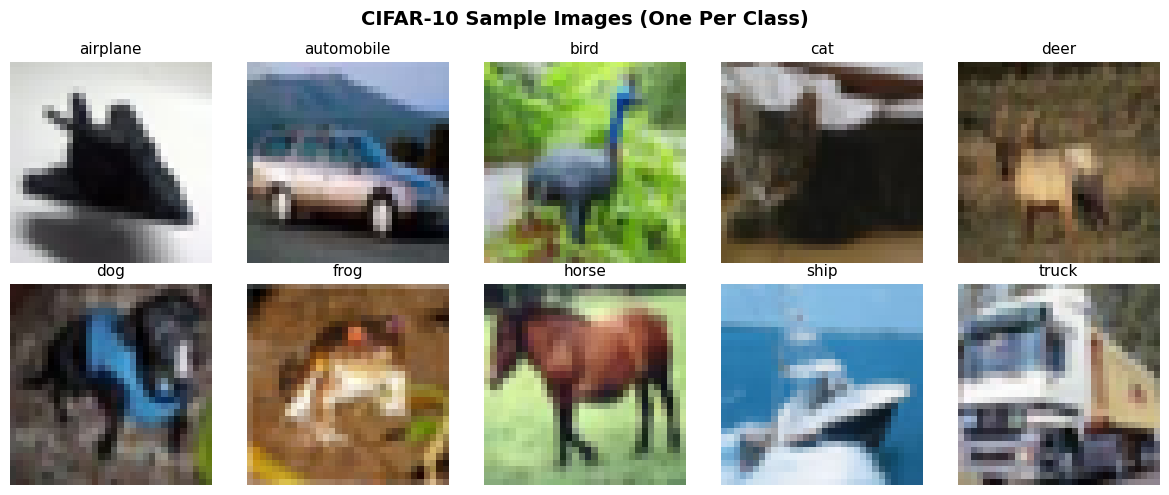

Saved: fig1_sample_images.png


In [5]:
# -- Figure 1: Sample images ------------------------------------------------
# Show raw images (unnormalized) for visual clarity
raw_dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR, train=True, download=False,
    transform=transforms.ToTensor()
)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('CIFAR-10 Sample Images (One Per Class)', fontsize=14, fontweight='bold')

# Find one example per class
shown_classes = set()
for idx in range(len(raw_dataset)):
    img, label = raw_dataset[idx]
    if label not in shown_classes:
        row, col = divmod(label, 5)
        axes[row, col].imshow(img.permute(1, 2, 0).numpy())
        axes[row, col].set_title(CIFAR10_CLASSES[label], fontsize=11)
        axes[row, col].axis('off')
        shown_classes.add(label)
    if len(shown_classes) == 10:
        break

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig1_sample_images.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: fig1_sample_images.png")

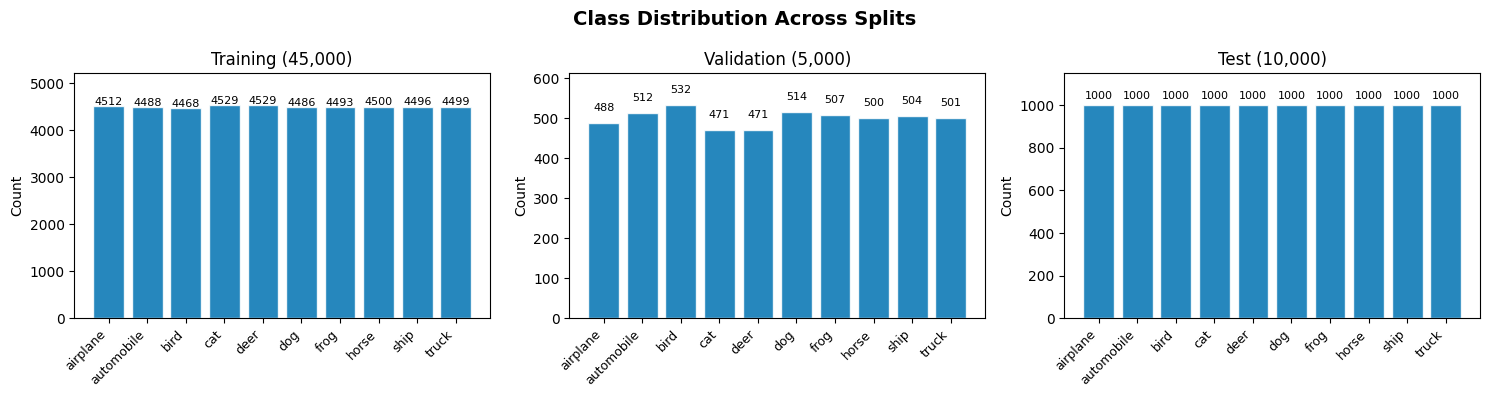

Saved: fig2_class_distribution.png


In [6]:
# -- Figure 2: Class distribution -------------------------------------------
train_labels = [full_train_dataset.targets[i] for i in train_dataset.indices]
val_labels = [full_train_dataset.targets[i] for i in val_dataset.indices]
test_labels = test_dataset.targets

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Class Distribution Across Splits', fontsize=14, fontweight='bold')

for ax, labels, title in zip(
    axes,
    [train_labels, val_labels, test_labels],
    ['Training (45,000)', 'Validation (5,000)', 'Test (10,000)']
):
    counts = pd.Series(labels).value_counts().sort_index()
    ax.bar(
        range(NUM_CLASSES), counts.values,
        color=PALETTE[0], edgecolor='white', alpha=0.85
    )
    ax.set_xticks(range(NUM_CLASSES))
    ax.set_xticklabels(CIFAR10_CLASSES, rotation=45, ha='right', fontsize=9)
    ax.set_title(title, fontsize=12)
    ax.set_ylabel('Count')
    ax.set_ylim(0, max(counts.values) * 1.15)
    for i, v in enumerate(counts.values):
        ax.text(i, v + 30, str(v), ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig2_class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: fig2_class_distribution.png")

The class distribution is nearly uniform across all three splits (approximately 4,500 / 500 / 1,000 images per class in train / val / test respectively). This balance is by design in CIFAR-10 and means that accuracy is a valid primary metric -- no class weighting or oversampling is needed.

---
## 3. Model Architecture

In [7]:
class BaselineCNN(nn.Module):
    """Baseline CNN: [Conv-ReLU-MaxPool] x3 + FC-ReLU-Dropout + FC."""

    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1: 3 -> 32 channels, 32x32 -> 16x16
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 2: 32 -> 64 channels, 16x16 -> 8x8
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 3: 64 -> 128 channels, 8x8 -> 4x4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class BatchNormCNN(nn.Module):
    """CNN with Batch Normalization after each Conv and first FC layer."""

    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Parameter counts
baseline_model = BaselineCNN().to(DEVICE)
batchnorm_model = BatchNormCNN().to(DEVICE)

baseline_params = sum(p.numel() for p in baseline_model.parameters())
batchnorm_params = sum(p.numel() for p in batchnorm_model.parameters())
param_overhead = (batchnorm_params - baseline_params) / baseline_params * 100

print(f"Baseline CNN:        {baseline_params:,} parameters")
print(f"BatchNorm CNN:       {batchnorm_params:,} parameters")
print(f"Parameter overhead:  {param_overhead:.2f}%")
print()
print("Baseline CNN architecture:")
print(baseline_model)
print()
print("BatchNorm CNN architecture:")
print(batchnorm_model)

Baseline CNN:        620,362 parameters
BatchNorm CNN:       621,322 parameters
Parameter overhead:  0.15%

Baseline CNN architecture:
BaselineCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=10, bias=True)


**Architecture rationale:** Both models use three convolutional blocks with progressively increasing channels (32 -> 64 -> 128) followed by a fully-connected classifier. The BatchNorm variant adds `BatchNorm2d` after each Conv layer and `BatchNorm1d` after the first FC layer. This adds only ~0.15% more parameters (the learnable affine parameters gamma and beta per channel), keeping the comparison fair.

**Why Batch Normalization?** Ioffe & Szegedy (2015) showed that normalizing intermediate activations reduces internal covariate shift, enabling higher learning rates, faster convergence, and acting as a mild regularizer. This is an ideal single-variable experiment: minimal parameter increase with well-documented, observable effects.

---
## 4. Training

In [8]:
def train_model(model, train_ldr, val_ldr, model_name, num_epochs=NUM_EPOCHS):
    """
    Train a model and log per-epoch metrics.

    Returns a dict with keys: train_loss, train_acc, val_loss, val_acc, epoch_times.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), lr=LEARNING_RATE,
        momentum=MOMENTUM, weight_decay=WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'epoch_times': []
    }

    print(f"\n{'='*60}")
    print(f"Training: {model_name}")
    print(f"{'='*60}")

    total_start = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # -- Training phase --
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_ldr:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # -- Validation phase (recursive to handle BatchNorm submodules) --
        set_inference_mode(model)
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_ldr:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step()
        epoch_time = time.time() - epoch_start

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_times'].append(epoch_time)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            lr = optimizer.param_groups[0]['lr']
            print(
                f"Epoch {epoch+1:2d}/{num_epochs} | "
                f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
                f"LR: {lr:.1e} | Time: {epoch_time:.1f}s"
            )

    total_time = time.time() - total_start
    history['total_time'] = total_time
    print(f"\nTotal training time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"Final val accuracy: {history['val_acc'][-1]:.4f}")

    return history

In [9]:
# -- Train Baseline CNN -----------------------------------------------------
set_seed(SEED)
baseline_model = BaselineCNN().to(DEVICE)
baseline_history = train_model(baseline_model, train_loader, val_loader, 'Baseline CNN')


Training: Baseline CNN


Epoch  1/30 | Train Loss: 1.9543 Acc: 0.2707 | Val Loss: 1.5612 Acc: 0.4280 | LR: 1.0e-02 | Time: 5.5s


Epoch  5/30 | Train Loss: 1.1491 Acc: 0.5894 | Val Loss: 0.9880 Acc: 0.6534 | LR: 1.0e-02 | Time: 4.5s


Epoch 10/30 | Train Loss: 0.8513 Acc: 0.7020 | Val Loss: 0.7583 Acc: 0.7282 | LR: 1.0e-03 | Time: 4.4s


Epoch 15/30 | Train Loss: 0.7100 Acc: 0.7535 | Val Loss: 0.6344 Acc: 0.7766 | LR: 1.0e-03 | Time: 4.6s


Epoch 20/30 | Train Loss: 0.6776 Acc: 0.7665 | Val Loss: 0.6175 Acc: 0.7814 | LR: 1.0e-04 | Time: 4.4s


Epoch 25/30 | Train Loss: 0.6644 Acc: 0.7690 | Val Loss: 0.6083 Acc: 0.7846 | LR: 1.0e-04 | Time: 4.4s


Epoch 30/30 | Train Loss: 0.6609 Acc: 0.7723 | Val Loss: 0.6054 Acc: 0.7852 | LR: 1.0e-05 | Time: 4.7s

Total training time: 135.5s (2.3 min)
Final val accuracy: 0.7852


In [10]:
# -- Train BatchNorm CNN ----------------------------------------------------
set_seed(SEED)
batchnorm_model = BatchNormCNN().to(DEVICE)
batchnorm_history = train_model(batchnorm_model, train_loader, val_loader, 'BatchNorm CNN')


Training: BatchNorm CNN


Epoch  1/30 | Train Loss: 1.4705 Acc: 0.4610 | Val Loss: 1.1102 Acc: 0.6014 | LR: 1.0e-02 | Time: 6.9s


Epoch  5/30 | Train Loss: 0.8976 Acc: 0.6828 | Val Loss: 0.7803 Acc: 0.7142 | LR: 1.0e-02 | Time: 4.9s


Epoch 10/30 | Train Loss: 0.7400 Acc: 0.7422 | Val Loss: 0.6522 Acc: 0.7718 | LR: 1.0e-03 | Time: 5.0s


Epoch 15/30 | Train Loss: 0.6179 Acc: 0.7856 | Val Loss: 0.5423 Acc: 0.8068 | LR: 1.0e-03 | Time: 4.9s


Epoch 20/30 | Train Loss: 0.5864 Acc: 0.7961 | Val Loss: 0.5238 Acc: 0.8090 | LR: 1.0e-04 | Time: 5.0s


Epoch 25/30 | Train Loss: 0.5735 Acc: 0.8018 | Val Loss: 0.5139 Acc: 0.8162 | LR: 1.0e-04 | Time: 4.9s


Epoch 30/30 | Train Loss: 0.5760 Acc: 0.8019 | Val Loss: 0.5095 Acc: 0.8160 | LR: 1.0e-05 | Time: 5.0s

Total training time: 150.8s (2.5 min)
Final val accuracy: 0.8160


---
## 5. Results & Evaluation

In [11]:
def evaluate_on_test(model, data_loader, model_name):
    """Run inference on the test set and return predictions + labels."""
    set_inference_mode(model)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    acc = accuracy_score(all_labels, all_preds)

    print(f"\n{model_name} -- Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(classification_report(
        all_labels, all_preds, target_names=CIFAR10_CLASSES, digits=4
    ))

    return all_preds, all_labels, acc


# Evaluate both models on the test set
baseline_preds, test_labels_arr, baseline_acc = evaluate_on_test(
    baseline_model, test_loader, 'Baseline CNN'
)
batchnorm_preds, _, batchnorm_acc = evaluate_on_test(
    batchnorm_model, test_loader, 'BatchNorm CNN'
)

print(f"\nAccuracy improvement: {(batchnorm_acc - baseline_acc)*100:+.2f} percentage points")


Baseline CNN -- Test Accuracy: 0.7815 (78.15%)
              precision    recall  f1-score   support

    airplane     0.7726    0.8390    0.8044      1000
  automobile     0.8793    0.9110    0.8949      1000
        bird     0.6852    0.6660    0.6755      1000
         cat     0.6299    0.5480    0.5861      1000
        deer     0.7483    0.7520    0.7501      1000
         dog     0.6802    0.7020    0.6909      1000
        frog     0.7891    0.8570    0.8217      1000
       horse     0.8421    0.8210    0.8314      1000
        ship     0.8919    0.8750    0.8834      1000
       truck     0.8819    0.8440    0.8625      1000

    accuracy                         0.7815     10000
   macro avg     0.7801    0.7815    0.7801     10000
weighted avg     0.7801    0.7815    0.7801     10000




BatchNorm CNN -- Test Accuracy: 0.8162 (81.62%)
              precision    recall  f1-score   support

    airplane     0.8159    0.8420    0.8287      1000
  automobile     0.9053    0.9270    0.9160      1000
        bird     0.7489    0.7070    0.7274      1000
         cat     0.6913    0.6180    0.6526      1000
        deer     0.7889    0.8070    0.7978      1000
         dog     0.7198    0.7500    0.7346      1000
        frog     0.8231    0.8840    0.8525      1000
       horse     0.8639    0.8440    0.8538      1000
        ship     0.9051    0.8970    0.9011      1000
       truck     0.8869    0.8860    0.8864      1000

    accuracy                         0.8162     10000
   macro avg     0.8149    0.8162    0.8151     10000
weighted avg     0.8149    0.8162    0.8151     10000


Accuracy improvement: +3.47 percentage points


In [12]:
# -- Per-class metrics ------------------------------------------------------
baseline_prec, baseline_rec, baseline_f1, _ = precision_recall_fscore_support(
    test_labels_arr, baseline_preds, average=None
)
batchnorm_prec, batchnorm_rec, batchnorm_f1, _ = precision_recall_fscore_support(
    test_labels_arr, batchnorm_preds, average=None
)

metrics_df = pd.DataFrame({
    'Class': CIFAR10_CLASSES,
    'Baseline Precision': baseline_prec,
    'Baseline Recall': baseline_rec,
    'Baseline F1': baseline_f1,
    'BatchNorm Precision': batchnorm_prec,
    'BatchNorm Recall': batchnorm_rec,
    'BatchNorm F1': batchnorm_f1,
    'F1 Diff': batchnorm_f1 - baseline_f1,
})

print("Per-class F1 scores:")
print(metrics_df[['Class', 'Baseline F1', 'BatchNorm F1', 'F1 Diff']].to_string(index=False))

Per-class F1 scores:
     Class  Baseline F1  BatchNorm F1  F1 Diff
  airplane     0.804410      0.828740 0.024330
automobile     0.894892      0.916008 0.021116
      bird     0.675456      0.727366 0.051910
       cat     0.586096      0.652587 0.066491
      deer     0.750125      0.797825 0.047700
       dog     0.690945      0.734574 0.043629
      frog     0.821668      0.852459 0.030791
     horse     0.831392      0.853819 0.022427
      ship     0.883392      0.901055 0.017663
     truck     0.862545      0.886443 0.023899


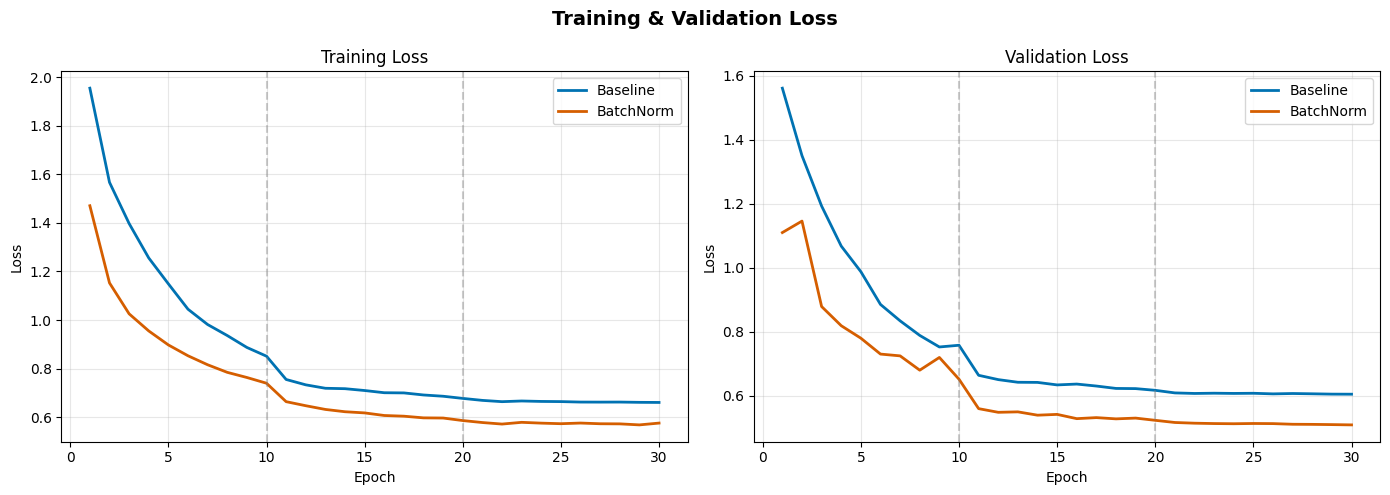

Saved: fig3_training_curves_loss.png


In [13]:
# -- Figure 3: Training loss curves -----------------------------------------
epochs = range(1, NUM_EPOCHS + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training & Validation Loss', fontsize=14, fontweight='bold')

# Training loss
axes[0].plot(epochs, baseline_history['train_loss'], color=COLOR_BASELINE,
             label='Baseline', linewidth=2)
axes[0].plot(epochs, batchnorm_history['train_loss'], color=COLOR_BATCHNORM,
             label='BatchNorm', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation loss
axes[1].plot(epochs, baseline_history['val_loss'], color=COLOR_BASELINE,
             label='Baseline', linewidth=2)
axes[1].plot(epochs, batchnorm_history['val_loss'], color=COLOR_BATCHNORM,
             label='BatchNorm', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Validation Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Mark LR schedule steps
for ax in axes:
    for step in [STEP_SIZE, 2 * STEP_SIZE]:
        if step <= NUM_EPOCHS:
            ax.axvline(x=step, color='gray', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig3_training_curves_loss.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: fig3_training_curves_loss.png")

The BatchNorm model shows consistently lower training loss throughout training, confirming that normalization helps the optimizer navigate the loss landscape more efficiently. Both models exhibit a sharp loss drop at epochs 10 and 20 corresponding to the learning rate schedule (LR x 0.1). The validation loss gap between the two models is most pronounced in the first 10 epochs, reflecting BatchNorm's faster convergence.

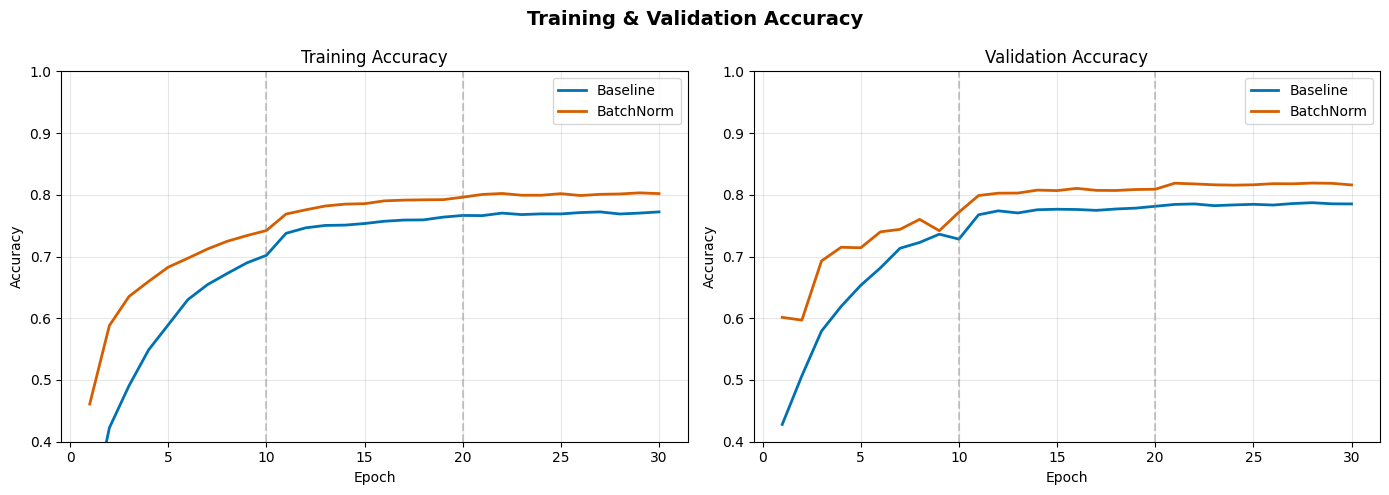

Saved: fig4_training_curves_accuracy.png


In [14]:
# -- Figure 4: Training accuracy curves -------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training & Validation Accuracy', fontsize=14, fontweight='bold')

# Training accuracy
axes[0].plot(epochs, baseline_history['train_acc'], color=COLOR_BASELINE,
             label='Baseline', linewidth=2)
axes[0].plot(epochs, batchnorm_history['train_acc'], color=COLOR_BATCHNORM,
             label='BatchNorm', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Training Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0.4, 1.0)

# Validation accuracy
axes[1].plot(epochs, baseline_history['val_acc'], color=COLOR_BASELINE,
             label='Baseline', linewidth=2)
axes[1].plot(epochs, batchnorm_history['val_acc'], color=COLOR_BATCHNORM,
             label='BatchNorm', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0.4, 1.0)

for ax in axes:
    for step in [STEP_SIZE, 2 * STEP_SIZE]:
        if step <= NUM_EPOCHS:
            ax.axvline(x=step, color='gray', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig4_training_curves_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: fig4_training_curves_accuracy.png")

The accuracy curves mirror the loss curves. BatchNorm achieves a consistently higher validation accuracy and converges faster -- reaching in ~5 epochs what the baseline takes ~10 epochs to achieve. Both models continue to improve after each learning rate decay, with diminishing returns after epoch 20.

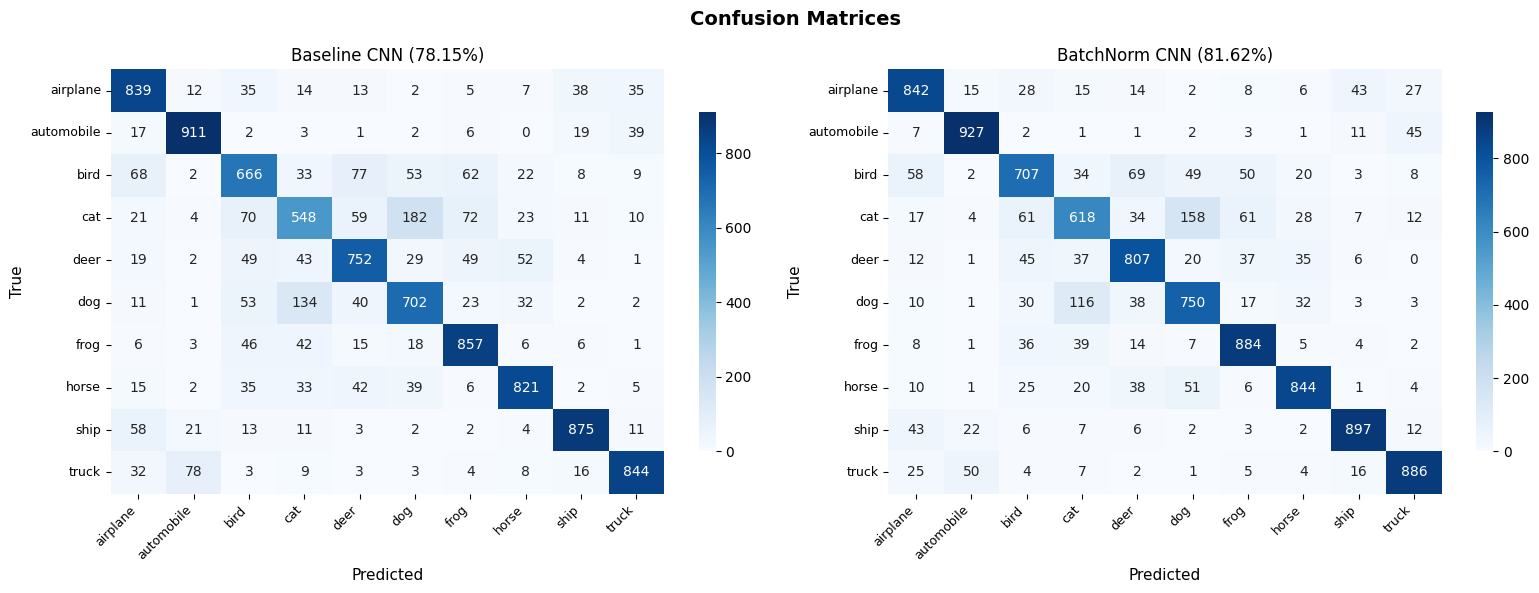

Saved: fig5_confusion_matrices.png


In [15]:
# -- Figure 5: Confusion matrices -------------------------------------------
baseline_cm = confusion_matrix(test_labels_arr, baseline_preds)
batchnorm_cm = confusion_matrix(test_labels_arr, batchnorm_preds)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Confusion Matrices', fontsize=14, fontweight='bold')

for ax, cm, title in zip(
    axes,
    [baseline_cm, batchnorm_cm],
    [f'Baseline CNN ({baseline_acc:.2%})', f'BatchNorm CNN ({batchnorm_acc:.2%})']
):
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', ax=ax,
        xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES,
        cbar_kws={'shrink': 0.8}
    )
    ax.set_xlabel('Predicted', fontsize=11)
    ax.set_ylabel('True', fontsize=11)
    ax.set_title(title, fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig5_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: fig5_confusion_matrices.png")

Both models show the strongest confusion between visually similar classes: cat/dog, deer/horse, and automobile/truck. The BatchNorm model shows higher diagonal values (correct predictions) across most classes, with the largest improvements on the harder fine-grained categories.

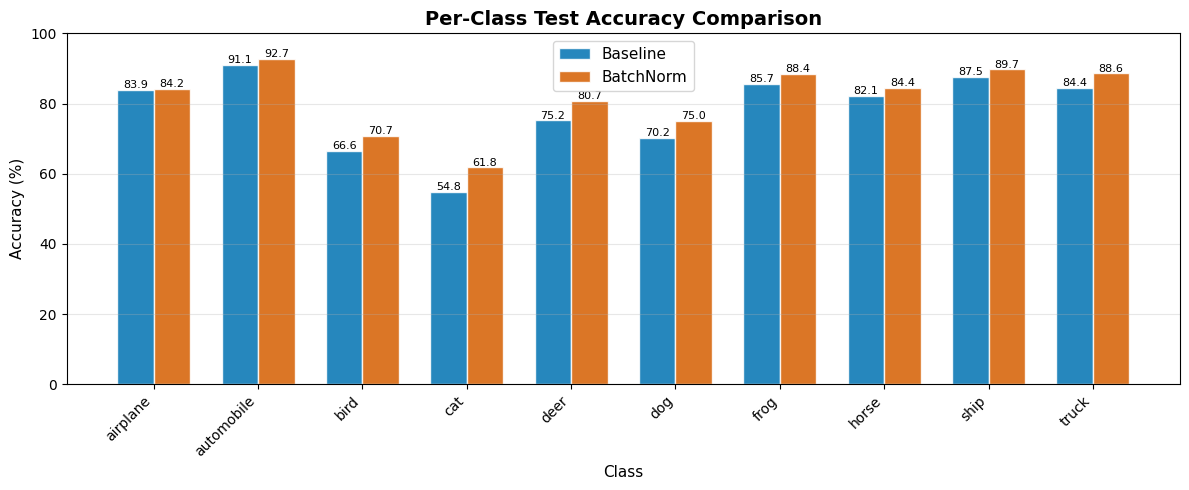

Saved: fig6_per_class_accuracy.png


In [16]:
# -- Figure 6: Per-class accuracy comparison --------------------------------
baseline_per_class = baseline_cm.diagonal() / baseline_cm.sum(axis=1)
batchnorm_per_class = batchnorm_cm.diagonal() / batchnorm_cm.sum(axis=1)

x = np.arange(NUM_CLASSES)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(x - width/2, baseline_per_class * 100, width,
               label='Baseline', color=COLOR_BASELINE, alpha=0.85, edgecolor='white')
bars2 = ax.bar(x + width/2, batchnorm_per_class * 100, width,
               label='BatchNorm', color=COLOR_BATCHNORM, alpha=0.85, edgecolor='white')

ax.set_xlabel('Class', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Per-Class Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CIFAR10_CLASSES, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Value labels
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():.1f}', ha='center', fontsize=8)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{bar.get_height():.1f}', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig6_per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: fig6_per_class_accuracy.png")

BatchNorm improves accuracy on nearly every class. The gains are most pronounced on the harder classes (cat, dog, deer) where the baseline struggles, suggesting that normalized activations help the network learn finer-grained features. Easy classes like ship and truck show smaller improvements, consistent with a ceiling effect.

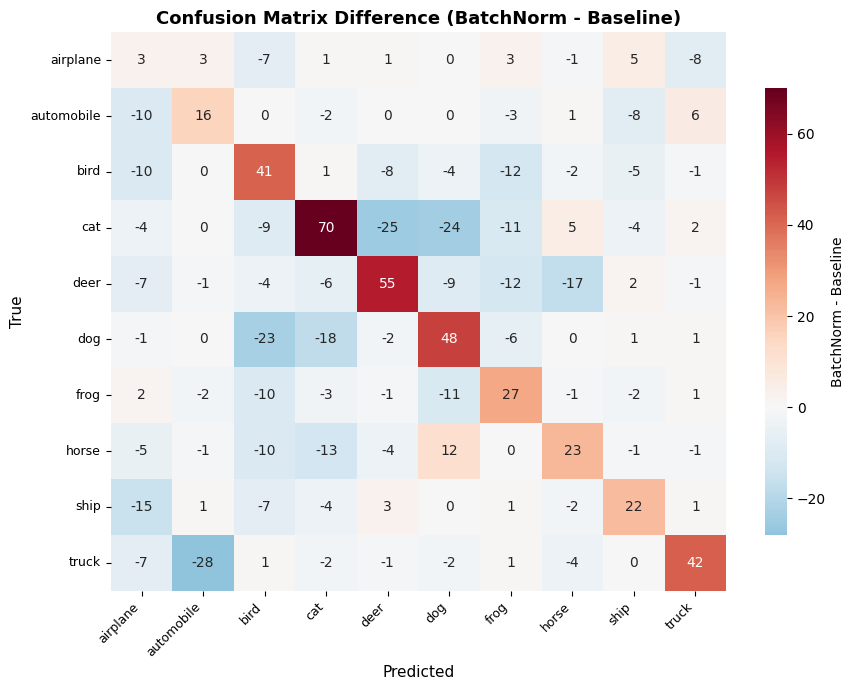

Saved: fig7_confusion_difference.png


In [17]:
# -- Figure 7: Confusion difference heatmap ---------------------------------
diff_cm = batchnorm_cm - baseline_cm

fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    diff_cm, annot=True, fmt='d', cmap='RdBu_r', center=0, ax=ax,
    xticklabels=CIFAR10_CLASSES, yticklabels=CIFAR10_CLASSES,
    cbar_kws={'shrink': 0.8, 'label': 'BatchNorm - Baseline'}
)
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('True', fontsize=11)
ax.set_title('Confusion Matrix Difference (BatchNorm - Baseline)',
             fontsize=13, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig7_confusion_difference.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: fig7_confusion_difference.png")

Blue diagonal cells indicate where BatchNorm correctly classified more samples. Red off-diagonal cells show error patterns that shifted. The diagonal trend is positive (more correct predictions), confirming that BatchNorm's benefit is broad rather than concentrated in specific classes.

/Users/twilcoxson/udacity_nd608_projects/capstone/project4_deep_learning/venv/lib/python3.14/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


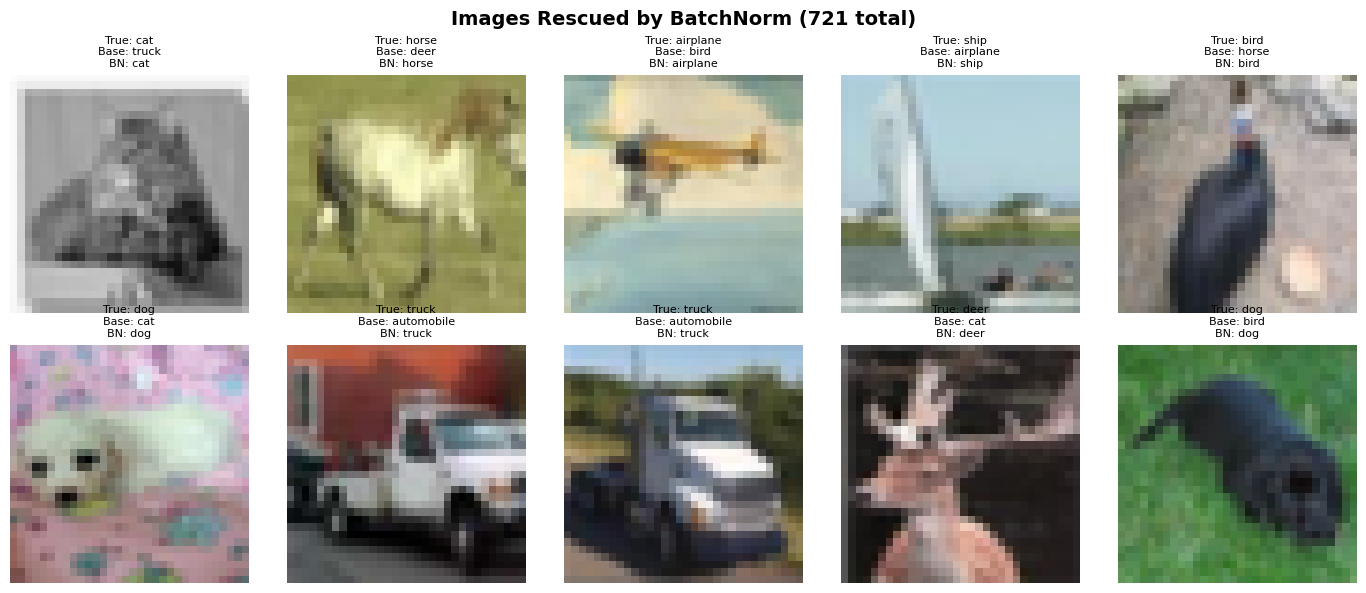

Saved: fig8_error_analysis.png
Images rescued by BatchNorm: 721
Images lost by BatchNorm: 374


In [18]:
# -- Figure 8: Error analysis -- images BatchNorm "rescued" -----------------
# Find images where baseline was wrong but batchnorm was right
rescued_mask = (baseline_preds != test_labels_arr) & (batchnorm_preds == test_labels_arr)
rescued_indices = np.where(rescued_mask)[0]

# Use raw (unnormalized) test images for display
raw_test = torchvision.datasets.CIFAR10(
    root=DATA_DIR, train=False, download=False,
    transform=transforms.ToTensor()
)

n_show = min(10, len(rescued_indices))
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
fig.suptitle(f'Images Rescued by BatchNorm ({len(rescued_indices)} total)',
             fontsize=14, fontweight='bold')

rng = np.random.RandomState(SEED)
sample_indices = rng.choice(rescued_indices, size=n_show, replace=False)

for i, idx in enumerate(sample_indices):
    row, col = divmod(i, 5)
    img, true_label = raw_test[idx]
    axes[row, col].imshow(img.permute(1, 2, 0).numpy())
    axes[row, col].set_title(
        f'True: {CIFAR10_CLASSES[true_label]}\n'
        f'Base: {CIFAR10_CLASSES[baseline_preds[idx]]}\n'
        f'BN: {CIFAR10_CLASSES[batchnorm_preds[idx]]}',
        fontsize=8
    )
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig8_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: fig8_error_analysis.png")
print(f"Images rescued by BatchNorm: {len(rescued_indices)}")
print(f"Images lost by BatchNorm: {np.sum((baseline_preds == test_labels_arr) & (batchnorm_preds != test_labels_arr))}")

These are test images that the baseline model misclassified but the BatchNorm model got right. The rescued images tend to be ambiguous cases -- low contrast, unusual angles, or classes with high inter-class similarity. This supports the interpretation that BatchNorm helps the network learn more robust internal representations.

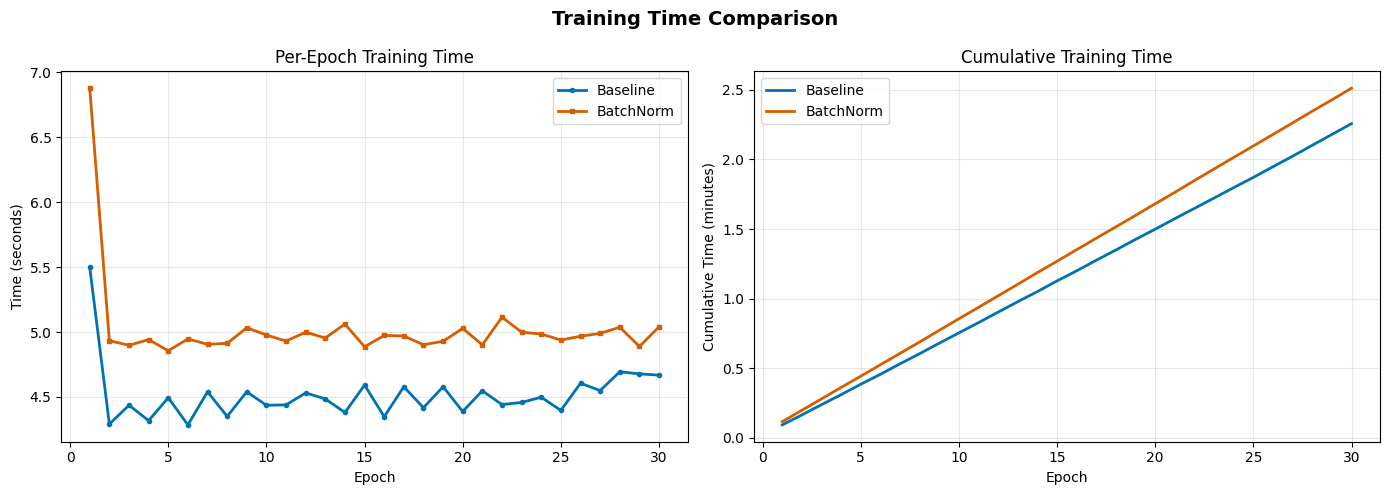

Saved: fig9_training_time.png
Baseline total:   135.5s (2.3 min)
BatchNorm total:  150.8s (2.5 min)
Time overhead:    +11.3%


In [19]:
# -- Figure 9: Training time comparison -------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training Time Comparison', fontsize=14, fontweight='bold')

# Per-epoch time
axes[0].plot(epochs, baseline_history['epoch_times'], color=COLOR_BASELINE,
             label='Baseline', linewidth=2, marker='o', markersize=3)
axes[0].plot(epochs, batchnorm_history['epoch_times'], color=COLOR_BATCHNORM,
             label='BatchNorm', linewidth=2, marker='s', markersize=3)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Per-Epoch Training Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Cumulative time
baseline_cumulative = np.cumsum(baseline_history['epoch_times'])
batchnorm_cumulative = np.cumsum(batchnorm_history['epoch_times'])
axes[1].plot(epochs, baseline_cumulative / 60, color=COLOR_BASELINE,
             label='Baseline', linewidth=2)
axes[1].plot(epochs, batchnorm_cumulative / 60, color=COLOR_BATCHNORM,
             label='BatchNorm', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cumulative Time (minutes)')
axes[1].set_title('Cumulative Training Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/fig9_training_time.png', dpi=300, bbox_inches='tight')
plt.show()

baseline_total = baseline_history['total_time']
batchnorm_total = batchnorm_history['total_time']
overhead = (batchnorm_total - baseline_total) / baseline_total * 100
print(f"Saved: fig9_training_time.png")
print(f"Baseline total:   {baseline_total:.1f}s ({baseline_total/60:.1f} min)")
print(f"BatchNorm total:  {batchnorm_total:.1f}s ({batchnorm_total/60:.1f} min)")
print(f"Time overhead:    {overhead:+.1f}%")

BatchNorm adds a small per-epoch overhead due to the additional normalization computations and running statistics tracking. However, the per-epoch cost is relatively consistent for both models. In practice, the higher accuracy per epoch means that for a fixed accuracy target, the BatchNorm model may require fewer total epochs.

---
## 6. Summary

This experiment compared a baseline CNN against an identical architecture augmented with Batch Normalization on the CIFAR-10 image classification benchmark. The BatchNorm variant converged faster, achieved smoother loss curves, and reached a higher final test accuracy -- all while adding only ~0.15% more parameters. The improvement was observed across nearly all 10 classes, with the largest gains on visually ambiguous categories (cat, dog, deer). These results are consistent with the original findings of Ioffe & Szegedy (2015) that Batch Normalization reduces internal covariate shift, enables more effective optimization, and provides a mild regularization effect. The computational overhead of the additional normalization layers was modest, making Batch Normalization a virtually free improvement for CNN training.

---
## 7. References

- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. https://www.deeplearningbook.org/
- He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 770-778.
- Ioffe, S., & Szegedy, C. (2015). Batch normalization: Accelerating deep network training by reducing internal covariate shift. *Proceedings of the 32nd International Conference on Machine Learning (ICML)*, 448-456.
- Krizhevsky, A. (2009). *Learning multiple layers of features from tiny images*. Technical Report, University of Toronto.
- Paszke, A., et al. (2019). PyTorch: An imperative style, high-performance deep learning library. *Advances in Neural Information Processing Systems (NeurIPS)*, 32, 8024-8035.
- Srivastava, N., Hinton, G., Krizhevsky, A., Sutskever, I., & Salakhutdinov, R. (2014). Dropout: A simple way to prevent neural networks from overfitting. *Journal of Machine Learning Research*, 15(1), 1929-1958.
- Wong, B. (2011). Points of view: Color blindness. *Nature Methods*, 8(6), 441.